In [60]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import numpy as np
import math
# 변환 활성화
pandas2ri.activate()

def import_r_data():
    # 1) 필수 패키지 로드
    ro.r('library(haven)')
    # 2) R-side 데이터 로드
    ro.r('fish <- read_dta("http://www.stata-press.com/data/r11/fish.dta")')
    # 3) Python으로 변환
    fish_df = pandas2ri.rpy2py(ro.r('fish'))
    return fish_df

# 사용 예
fish = import_r_data()
print(type(fish))   # pandas.DataFrame
print(fish.head())

! curl package not installed, falling back to using `url()`
<class 'pandas.core.frame.DataFrame'>
   nofish  livebait  camper  persons  child        xb        zg  count
1     1.0       0.0     0.0      1.0    0.0 -0.896315  3.050405    0.0
2     0.0       1.0     1.0      1.0    0.0 -0.558345  1.746149    0.0
3     0.0       1.0     0.0      1.0    0.0 -0.401731  0.279939    0.0
4     0.0       1.0     1.0      2.0    1.0 -0.956298 -0.601526    0.0
5     0.0       1.0     0.0      1.0    0.0  0.436891  0.527709    1.0


## Single Modal data

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import poisson

# ===========================
# 0) 데이터 로드 및 디자인 행렬 정의
# ===========================
# fish DataFrame이 이미 로드되어 있는 상태라고 가정합니다.
# 예시: fish = pd.read_csv("your_fish_data.csv")

y_int = fish["count"].values.astype(int) # 관측값
X = np.column_stack([np.ones(len(fish)), fish[["persons"]].values]) # 디자인 행렬 X : 여기서 person임
Z = np.column_stack([np.ones(len(fish)), fish[["camper"]].values]) # 디자인 행렬 Z : 여기서 camper임

# ===========================
# 1) ZIPAP 클래스 정의
# ===========================
class ZIPAP:
    def __init__(self, X, Z, degree=3, alpha_init_eps=1e-2):
        self.X = np.asarray(X) # 람다 회귀용
        self.Z = np.asarray(Z) # Pi 회귀용
        self.n, self.p = self.X.shape # 관측치 수 
        _, self.q = self.Z.shape # π 회귀 파라미터 γ의 차원
        self.d = degree # 다항조정자의 차수
        self.beta  = np.zeros(self.p) #  로그it(π) 회귀용 γ 벡터를 0으로 초기화
        self.gamma = np.zeros(self.q) #  로그it(π) 회귀용 γ 벡터를 0으로 초기화
        self.alpha = np.concatenate(([1.0], np.full(self.d, alpha_init_eps))) # [1.0]은 alpha_{0}부근, 나머지는 1e-2로 설정하여 알파값이 이상한 값이 나오지 않도록 설정

    def _T(self, y): # propositon 2.2; dentifiability and Validity of the Polynomial Adjuster을 구현한 부분임/
        y = np.asarray(y)
        return sum(self.alpha[k] * (y**k) for k in range(self.d+1)) # 

    def _Z(self, lam):
        lam = np.asarray(lam)
        if self.d <= 4:
            # closed-form moments
            m0 = np.ones_like(lam) # mu0(lambda) =1
            m1 = lam # mu0(lambda) = lambda
            m2 = lam**2 + lam  # mu2(lambda) = lambda^2 + lambda
            
            m3 = lam**3 + 3*lam**2 + lam
            m4 = lam**4 + 6*lam**3 + 7*lam**2 + lam

            Zval = self.alpha[0]*m0 # thm 2.3(c)의 수식으로 풀이 될 수 있음

            # 이때 차수가 d가 0,1,2,3,4일 때를 대비해 필요 모멘트 까지만 더할 수 있도록 한 코드임.
            if self.d>=1: Zval += self.alpha[1]*m1 
            if self.d>=2: Zval += self.alpha[2]*m2
            if self.d>=3: Zval += self.alpha[3]*m3
            if self.d>=4: Zval += self.alpha[4]*m4
            return Zval
        
        # numeric truncation 30 부근까지만 계산해서 보여줘야 함
        Ymax = max(30, int(np.max(lam) + 10*self.d))
        ys = np.arange(Ymax+1)

        # 이를 위한 
        pmf_vals = np.vstack([poisson.pmf(ys, lam_i) for lam_i in lam])
        T_vals = np.vstack([self._T(ys) for _ in lam])

        return (pmf_vals * T_vals).sum(axis=1)
    
    # regresion parameters과 대응됨
    def _pi_lambda(self):
        eta = self.Z.dot(self.gamma) # (logit 링크의 선형 예측자)
        pi = 1/(1+np.exp(-eta)) # logit 링크의 역함수 -> Pi 계산
        lam = np.exp(self.X.dot(self.beta)) # lambda를 양수로 보장하기 위한 로그 링크 연산
        return pi, lam

    def pmf(self, y):
        y = np.asarray(y)
        pi, lam = self._pi_lambda() # _pi_lambda(self) 의 zero inflation parameter pi와 Poisson parameter lambda를 계산값을 호출함
        T_y = self._T(y) # 다항식 가중치 함수 T 계산값에 대해서 호출함.
        Z_l = self._Z(lam) # 정규화 상수 계산값을 호출함
        p = np.zeros_like(y, float) 
        
        # 여기서부터 논문 proposition 2.1 부분의 조건문 분기를 위한 식 생성
        mask0 = (y==0) 

        if mask0.any():
            p0 = poisson.pmf(0, lam[mask0]) * T_y[mask0]/Z_l[mask0] 
            p[mask0] = pi[mask0] + (1-pi[mask0]) * p0
        
        maskp = (y>0) # y가 0보다 큰 경우를 위한 마스크
        if maskp.any():
            pp = poisson.pmf(y[maskp], lam[maskp]) * T_y[maskp]/Z_l[maskp]
            p[maskp] = (1-pi[maskp]) * pp
        return p

    def log_lik(self, theta):
        self.beta = theta[:self.p] # θ에서 beta 파라미터를 추출 -> log lambda 파라미터
        self.gamma = theta[self.p:self.p+self.q] # θ에서 gamma 파라미터를 추출 -> logit pi 파라미터
        self.alpha[1:] = np.abs(theta[self.p+self.q:]) # θ 에서 α₁…α_d 분리 및 비음수 제약 -> 다항조정자 부분 
        vals = np.clip(self.pmf(self._y), 1e-12, None) # f(Yᵢ; θ) 계산, 0으로 나누는 것을 방지하기 위해 최소값을 1e-12로 설정

        return -np.sum(np.log(vals)) # 음의 로그우도 계산
    
    # 초기화 단계: 초기 모멘트 계산
    def init_moments(self, y, alpha_init_eps):
        mu, var = y.mean(), y.var()
        pi0 = np.clip(1 - var/mu, 1e-3, 1-1e-3)
        lam0 = mu/(1-pi0)
        Xmean = self.X.mean(axis=0)
        self.gamma = np.array([np.log(pi0/(1-pi0))] + [0]*(self.q-1))
        self.beta = np.log(lam0) - np.log(Xmean)
        self.alpha = np.concatenate(([1.0], np.full(self.d, alpha_init_eps)))

    def to_theta(self):
        return np.concatenate([self.beta, self.gamma, self.alpha[1:]])

    def fit(self, y, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1):
        self._y = y.copy() # y값을 복사한다.
        self.init_moments(self._y, initial_alpha_eps) # 
        theta0 = self.to_theta() # 초기 파라미터 벡터 θ₀ 생성 여기서 theta0는 beta, gamma, alpha를 포함하는 벡터임.
        
        bounds = [(None,None)]*(self.p+self.q) + [(0,None)]*self.d # β, γ(로그 링크/로그릿 링크)는 아무 값이나 허용 (None,None) / alpha는 양수값 제약
        res = opt.minimize(self.log_lik, theta0, method=method, bounds=bounds) # 최적화 시도 -> method = 'L-BFGS-B'로 설정
        
        if not res.success: # 최적화 실패시 retry_alpha_eps을 사용하여 초기값을 다시 설정함.
            self.init_moments(self._y, retry_alpha_eps)
            res2 = opt.minimize(self.log_lik, self.to_theta(), method=method, bounds=bounds)
            
            # 두 번째 최적화가 성공하면 결과를 업데이트
            if res2.success:
                res = res2
            # 두번째 최적화를 했는데 안되면 Nelder-Mead 기법을 시도
            else:
                res3 = opt.minimize(self.log_lik, self.to_theta(), method='Nelder-Mead')
                if not res3.success:
                    raise RuntimeError("Optimization failed")
                res = res3
        # 최적화 성공시 각 차수에 대한 정보 저장                
        self.beta = res.x[:self.p]
        self.gamma = res.x[self.p:self.p+self.q]
        self.alpha[1:] = np.abs(res.x[self.p+self.q:])
        return res
    
    # 예측 
    def predict_mean(self):
        pi, lam = self._pi_lambda()
        return (1-pi)*lam

    # AIC, BIC 계산
    def aic(self):
        k = self.p + self.q + self.d
        return 2*k + 2*self.log_lik(self.to_theta())

    def bic(self):
        k = self.p + self.q + self.d
        return np.log(self.n)*k + 2*self.log_lik(self.to_theta())

# ===========================
# 2) Table 1: Parameter estimates for ZIP and zPAP models
# ===========================
models = {}
results = {}
degrees = [0,1,2,3]
for d in degrees:
    m = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-2)
    res = m.fit(y_int, initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)
    models[d] = m
    # Collect parameter estimates
    params = {
        'beta0': m.beta[0],
        'beta1': m.beta[1],
        'gamma0': m.gamma[0],
        'gamma1': m.gamma[1]
    }
    # alphas
    for k in range(1, d+1):
        params[f'alpha{k}'] = m.alpha[k]
    # stats
    params['logLik'] = -res.fun
    params['AIC'] = m.aic()
    params['BIC'] = m.bic()
    results[d] = params

# Build DataFrame
rows = ['beta0','beta1','gamma0','gamma1','alpha1','alpha2','alpha3','logLik','AIC','BIC']
col_map = {0:'ZIP',1:'zPAP(1)',2:'zPAP(2)',3:'zPAP(3)'}

df = pd.DataFrame(index=rows, columns=[col_map[d] for d in degrees])
for d in degrees:
    for r in rows:
        df.at[r, col_map[d]] = results[d].get(r, np.nan)

# Display table
print("Table 1: MLE estimates for ZIP and zPAP models")
print(df.to_markdown(floatfmt=".3f"))


In [ ]:
# 1. ZIP 모델 추정
from statsmodels.discrete.count_model import ZeroInflatedPoisson

zip_model = ZeroInflatedPoisson(endog=y_int, exog=X, exog_infl=Z, inflation='logit')
zip_result = zip_model.fit()

zip_result.summary()

ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")

ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")

pi_hat = np.mean(zip_probs[:, 0])
print(f"Zero Probability (π) from ZIP model: {pi_hat:.4f}")

import matplotlib.pyplot as plt
import numpy as np

# 0~30 범위로 설정
ys = np.arange(0, 31)

# 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=31)
obs_probs = obs_counts / obs_counts.sum()

# ZIP 예측 분포 (전체 중 앞 31개)
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)
zip_probs_avg = np.mean(zip_probs, axis=0)[:31]

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(ys, obs_probs[:31], width=0.8, alpha=0.4, label="Observed", color="gray")
plt.plot(ys, zip_probs_avg, marker="o", linestyle="-", color="blue", label="ZIP predicted")
plt.xlabel("Count (y)")
plt.ylabel("Probability")
plt.title("ZIP Model Fit vs. Observed Distribution (y ≤ 30)")
plt.ylim(0, max(obs_probs[:31].max(), zip_probs_avg.max()) * 1.1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 0~30 구간만
ys = np.arange(0, 31)

# 관측 빈도
obs_counts = np.bincount(y_int.astype(int), minlength=31)
obs_freq = obs_counts / obs_counts.sum()

# statsmodels ZIP 예측 확률 (n, y) → 평균
zip_probs = zip_model.predict(params=zip_result.params, exog=X, exog_infl=Z, which='prob')
zip_probs_avg = np.mean(zip_probs, axis=0)[:31]

# zPAP 계열 PMF 추정
def pmf_population(model, y_vals):
    pi, lam = model._pi_lambda()
    Z_l = model._Z(lam)
    out = []
    for y in y_vals:
        T_y = model._T(np.array([y]))
        if y == 0:
            p_i = pi + (1 - pi) * poisson.pmf(0, lam) * T_y / Z_l
        else:
            p_i = (1 - pi) * poisson.pmf(y, lam) * T_y / Z_l
        out.append(p_i.mean())
    return np.array(out)

# 모델 학습 및 PMF
degrees = [1, 2, 3]
colors = {0: "blue", 1: "red", 2: "green", 3: "orange"}
pmfs = {}
for d in degrees:
    m = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-1)
    m.fit(y_int, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)
    pmfs[d] = pmf_population(m, ys)

# --- 시각화 ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# (0, 0) ZIP: statsmodels 예측
ax = axes[0, 0]
ax.bar(ys, obs_freq[:31], color="gray", alpha=0.4, label="Observed")
ax.plot(ys, zip_probs_avg, label="ZIP (statsmodels)", color="blue", linestyle='-', linewidth=2)
ax.set_title("ZIP (statsmodels)")
ax.set_xlim(0, 30)
ax.set_ylim(0, max(obs_freq.max(), zip_probs_avg.max()) * 1.1)
ax.grid(True); ax.legend()

# 나머지 zPAP(1~3)
for i, d in enumerate(degrees):
    ax = axes[(i+1)//2, (i+1)%2]
    lbl = f"zPAP K={d}"
    ax.bar(ys, obs_freq[:31], color="gray", alpha=0.4, label="Observed")
    ax.plot(ys, pmfs[d], label=lbl, color=colors[d], linestyle='--', linewidth=2)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, max(obs_freq[:31].max(), max(pmfs[d])) * 1.1)
    ax.set_title(lbl)
    ax.grid(True); ax.legend()

fig.supxlabel("Count")
fig.supylabel("Probability")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# ===========================
# ZIP 모델 (statsmodels) + zPAP(d) 모델 피팅 후 Table 1 결과 생성 및 시각화
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from scipy.stats import poisson

# statsmodels ZIP 모델 적합
zip_model = ZeroInflatedPoisson(endog=y_int, exog=X, exog_infl=Z, inflation='logit')
zip_result = zip_model.fit()

# ZIP 예측 결과
zip_probs = zip_model.predict(params=zip_result.params, exog=X, exog_infl=Z, which='prob')
zip_probs_avg = np.mean(zip_probs, axis=0)[:31]
beta_hat = zip_result.params[:X.shape[1]]
lambda_hat = np.exp(X @ beta_hat)
lambda_mean = np.mean(lambda_hat)
pi_hat = np.mean(zip_probs[:, 0])

# 관측값 분포 (0~30까지)
ys = np.arange(0, 31)
obs_counts = np.bincount(y_int.astype(int), minlength=31)
obs_probs = obs_counts / obs_counts.sum()

# ===========================
# zPAP(d) 모델 피팅 및 Table 1 결과 생성
# ===========================
results = {0: {
    'beta0': round(beta_hat[0], 3),
    'beta1': round(beta_hat[1], 3),
    'gamma0': round(zip_result.params[X.shape[1]], 3),
    'gamma1': round(zip_result.params[X.shape[1]+1], 3),
    'logLik': round(zip_result.llf, 3),
    'AIC': round(zip_result.aic, 3),
    'BIC': round(zip_result.bic, 3),
}}

for d in [1, 2, 3]:
    model = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-2)
    res = model.fit(y_int, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)

    row = {
        'beta0': round(model.beta[0], 3),
        'beta1': round(model.beta[1], 3),
        'gamma0': round(model.gamma[0], 3),
        'gamma1': round(model.gamma[1], 3),
        'logLik': round(-res.fun, 3),
        'AIC': round(model.aic(), 3),
        'BIC': round(model.bic(), 3),
    }
    for k in range(1, d+1):
        row[f'alpha{k}'] = round(model.alpha[k], 3)
    results[d] = row

# DataFrame 생성 및 출력
columns = ['beta0', 'beta1', 'gamma0', 'gamma1', 'alpha1', 'alpha2', 'alpha3', 'logLik', 'AIC', 'BIC']
df = pd.DataFrame(results).T[columns]
df.index = ['ZIP', 'zPAP(1)', 'zPAP(2)', 'zPAP(3)']
print("Table 1: MLE estimates for ZIP and zPAP models")
print(df.to_markdown(tablefmt="grid"))

### ZIPAP Mutlmodal


In [ ]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from functools import lru_cache

# ============================================================
# 0) 데이터 로드 및 전처리 (y=0..30)
# ============================================================
counts = fish["count"].astype(int).values # fish data 생성
rng    = np.random.RandomState(42) # 랜덤샘플링을 시도할 때 
y_p10  = rng.poisson(lam=10, size=len(counts))

y_all  = np.concatenate([counts, y_p10])
y_all  = y_all[(y_all >= 0) & (y_all <= 30)]   # 0 포함, 상한 30

# ============================================================
# 1) Poisson raw‐moments via Stirling numbers
# ============================================================
# 이전코드에서는 하드코딩으로 모멘트 합을 구했지만, 차후 대용량 데이터를 반영하게 되면 연산량이 많아지게 됨. 그렇기에 스털링 수를 사용해서 빠른 연산이 되도록 도와준다.
# 그냥 모멘트 합이라고 생각하면 쉬움

@lru_cache(None) # 
def S(n, k): # 
    if n==k==0: return 1 # 
    if n==0 or k==0 or k>n: return 0 # 
    return S(n-1, k-1) + k*S(n-1, k) # 


def poisson_raw_moment(j, lam): # 
    lam = np.asarray(lam, float) 
    if j==0: return np.ones_like(lam)
    if j==1: return lam
    if j==2: return lam**2 + lam
    if j==3: return lam**3 + 3*lam**2 + lam
    out = np.zeros_like(lam)
    for k in range(j+1):
        out += S(j,k)*lam**k
    return out

# ============================================================
# 2) SoS 전개로 α 벡터 계산
# ============================================================
# Sum of Square (SoS) 전개를 사용하여 α 벡터를 계산하는 함수
def compute_alpha(u, v):
    r0, r1 = len(u)-1, len(v)-1
    d = max(2*r0, 1+2*r1)
    α = np.zeros(d+1)
    α[0] = 1.0
    # s0^2
    for i in range(r0+1):
        for j in range(r0+1):
            if i==0 and j==0: continue
            α[i+j] += u[i]*u[j]
    # y·s1^2
    for p in range(r1+1):
        for q in range(r1+1):
            α[p+q+1] += v[p]*v[q]
    return α

# ============================================================
# 3) Zero‐Inflated PAP Negative Log‐Likelihood
# ============================================================

def zipap_negloglik(theta, y, r0, r1):
    # unpack
    loglam   = theta[0] # 단일 λ 값을 추정하므로, 그냥 loglam 하나만 가지고 전역 λ 를 np.exp(loglam) 으로 복원
    u1       = theta[1:1+r0]
    v        = theta[1+r0:1+r0+(r1+1)]
    logit_pi = theta[-1]
    lam      = np.exp(loglam) # loglam 은 단일한 로그 Poisson rate 파라미터
    pi       = 1/(1+np.exp(-logit_pi)) # logit_pi 는 단일한 로그릿(zero‐inflation 확률) 파라미터 

    u        = np.concatenate(([1.0], u1)) # u 벡터는 1.0을 포함한 벡터
    α_vec    = compute_alpha(u, v) # 알파연산 함수

    # normalization Z = Σ α_j E[Y^j] -> 정규화 상수 Z(lambdam, alpha)
    Z = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))

    ll = 0.0 # 로그함수 값 초기화
    for yi in y: # 각 관측치에 대해서 계산
        # 다항식 가중치 T(y) 계산 -> SoS 전개를 사용하여 T(y) 계산
        T = u.dot([yi**k for k in range(len(u))])**2
        if len(v)>0:
            T += yi*(v.dot([yi**k for k in range(len(v))])**2)

        # PAP‐Poisson 결합 밀도 (unnormalized) 이때 Base rk : 논문 9page 구성
        base = T * poisson.pmf(yi, lam) / Z

        # 0부근 
        if yi==0:
            p = pi + (1-pi)*base
        
        # 0 제외 부분 피팅
        else:
            p = (1-pi)*base
        ll += np.log(p + 1e-16) # 수치적 안정성을 위해서 1e-16을 지정
    
    return -ll # 로그우도 값 생성

class ZIPAP:
    def __init__(self, degree, y):
        self.r0 = degree//2
        self.r1 = (degree-1)//2 if degree>0 else -1
        self.y  = y
        # θ = [loglam, u1..u_r0, v0..v_r1, logit_pi]
        self.theta = np.zeros(1+self.r0+(self.r1+1)+1)

    def fit(self):
        res = minimize(
            zipap_negloglik,
            self.theta,
            args=(self.y, self.r0, self.r1),
            method='L-BFGS-B'
        )
        if not res.success:
            raise RuntimeError("Optimization failed: "+res.message)
        self.theta = res.x
        return res

    def pmf(self, yi):
        loglam   = self.theta[0]
        u1       = self.theta[1:1+self.r0]
        v        = self.theta[1+self.r0:1+self.r0+(self.r1+1)]
        logit_pi = self.theta[-1]
        lam      = np.exp(loglam)
        pi       = 1/(1+np.exp(-logit_pi))
        u        = np.concatenate(([1.0], u1))
        α_vec    = compute_alpha(u, v)
        Z        = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))
        T        = u.dot([yi**k for k in range(len(u))])**2
        
        if len(v)>0:
            T += yi*(v.dot([yi**k for k in range(len(v))])**2)
        base = T * poisson.pmf(yi, lam) / Z
        return (pi + (1-pi)*base) if yi==0 else (1-pi)*base

# ============================================================
# 4) degree=0..4 모델 학습 & 평가
# ============================================================
y_grid = np.arange(0,31)
hist, _ = np.histogram(y_all, bins=np.arange(-0.5,31.5,1), density=True)

results = []
models  = {}
for d in range(5):
    m = ZIPAP(degree=d, y=y_all)
    res = m.fit()
    models[d] = m

    # 추정된 λ, π
    lam_est = np.exp(m.theta[0])
    pi_est  = 1/(1 + np.exp(-m.theta[-1]))

    ll      = -zipap_negloglik(m.theta, y_all, m.r0, m.r1)
    K       = len(m.theta)
    AIC     = 2*K - 2*ll
    pmf_vals = np.array([m.pmf(yi) for yi in y_grid])
    MSE     = np.mean((hist - pmf_vals)**2)

    # α 벡터
    u1     = m.theta[1:1+m.r0]
    v      = m.theta[1+m.r0:1+m.r0+(m.r1+1)]
    α_vec  = compute_alpha(np.concatenate(([1.0],u1)), v)

    results.append({
        'degree': d,
        'lambda': lam_est,
        'pi': pi_est,
        'logLik': ll,
        'AIC':    AIC,
        'MSE':    MSE,
        'alpha':  α_vec
    })

# 콘솔 테이블 출력
print(" d | lambda  |   pi    |    logLik    |    AIC    |     MSE     |       α vector")
print("---+---------+---------+--------------+-----------+-------------+------------------------")
for r in results:
    d, lam, pi, ll, AIC, MSE, α = r['degree'], r['lambda'], r['pi'], r['logLik'], r['AIC'], r['MSE'], r['alpha']
    print(f"{d:2d} | {lam:7.4f} | {pi:7.4f} | {ll:12.4f} | {AIC:9.2f} | {MSE:11.4e} | {np.round(α,4)}")

# ============================================================
# 5) PMF 오버레이 플롯 (ZIPAP d=0..4)
# ============================================================
plt.figure(figsize=(10,6))
plt.bar(y_grid, hist, width=0.8, color='lightgray', alpha=0.6, label='Observed')
for d, mdl in models.items():
    pmf_d = [mdl.pmf(yi) for yi in y_grid]
    plt.plot(y_grid, pmf_d, marker='o', label=f'd={d}')
plt.xlabel('Count $y$')
plt.ylabel('Probability')
plt.title('Zero‐Inflated PAP PMF Overlay (d=0..4)')
plt.legend(title='Degree', fontsize='small', ncol=2)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 5) 콘솔 테이블 출력 (degree 0과 4만)
# ============================================================
print(' d | lambda  |   pi    |    logLik    |    AIC    |     MSE     |       α vector')
print('---+---------+---------+--------------+-----------+-------------+------------------------')
for r in results:
    if r['degree'] in (0, 4):
        d, lam, pi, ll, AIC, MSE, α = r['degree'], r['lambda'], r['pi'], r['logLik'], r['AIC'], r['MSE'], r['alpha']
        print(f'{d:2d} | {lam:7.4f} | {pi:7.4f} | {ll:12.4f} | {AIC:9.2f} | {MSE:11.4e} | {np.round(α,4)}')

# ============================================================
# 6) PMF 오버레이 플롯 (ZIPAP d=0 and 4 only)
# ============================================================
plt.figure(figsize=(10,6))
plt.bar(y_grid, hist, width=0.8, color='lightgray', alpha=0.6, label='Observed')
for d in (0, 4):
    mdl = models[d]
    pmf_d = [mdl.pmf(yi) for yi in y_grid]
    if d == 0:
        plt.plot(y_grid, pmf_d, marker='o', label='ZIP', color='C0')
    else:
        plt.plot(y_grid, pmf_d, marker='o', label=f'ZIPAP({d})', color='C3')
plt.xlabel('Count $y$')
plt.ylabel('Probability')
plt.legend(title='Degree', fontsize='small', ncol=2)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 7) 차이 플롯 (Histogram - PMF for degree 0 vs 4)
# ============================================================
# y support 및 히스토그램 (0부터 30까지)
y_grid_diff = np.arange(0, 31)
hist_diff, _ = np.histogram(y_all, bins=np.arange(-0.5, 31.5), density=True)

# 모델별 PMF 계산
pmf0 = np.array([models[0].pmf(yi) for yi in y_grid_diff])
pmf4 = np.array([models[4].pmf(yi) for yi in y_grid_diff])

# 차이 계산
diff_0 = hist_diff - pmf0
diff_4 = hist_diff - pmf4

# 시각화

# degree=0 (ZIP)
plt.vlines(y_grid_diff, 0, diff_0, color='blue', linewidth=1)
plt.plot(y_grid_diff, diff_0, 'ro', markersize=6, label = "ZIP")
plt.axhline(0, color='black', linewidth=1)

plt.ylabel('Histogram - PMF')

plt.grid(True)

# degree=4 (ZIPAP)
plt.vlines(y_grid_diff, 0, diff_4, color='orange', linewidth=1)
plt.plot(y_grid_diff, diff_4, 'g^', markersize=6, label = "ZIPAP(4)")
plt.axhline(0, color='black', linewidth=1)
plt.xlim(-0.5, 30.5)
plt.xlabel('Count')

plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 7) 차이 플롯 (Histogram - PMF for degree 0 vs 4)
# ============================================================
# y support 및 히스토그램 (0부터 30까지)
y_grid_diff = np.arange(0, 31)
hist_diff, _ = np.histogram(y_all, bins=np.arange(-0.5, 31.5), density=True)

# 모델별 PMF 계산
pmf0 = np.array([models[0].pmf(yi) for yi in y_grid_diff])
pmf4 = np.array([models[4].pmf(yi) for yi in y_grid_diff])

# 차이 계산
diff_0 = hist_diff - pmf0
diff_4 = hist_diff - pmf4

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# degree=0 (ZIP)
axs[0].vlines(y_grid_diff, 0, diff_0, color='blue', linewidth=1)
axs[0].plot(y_grid_diff, diff_0, 'ro', markersize=6)
axs[0].axhline(0, color='black', linewidth=1)
axs[0].set_xlim(-0.5, 30.5)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Histogram - PMF')
axs[0].set_title('Degree 0 Difference')
axs[0].grid(True)

# degree=4 (ZIPAP)
axs[1].vlines(y_grid_diff, 0, diff_4, color='orange', linewidth=1)
axs[1].plot(y_grid_diff, diff_4, 'g^', markersize=6)
axs[1].axhline(0, color='black', linewidth=1)
axs[1].set_xlim(-0.5, 30.5)
axs[1].set_xlabel('Count')
axs[1].set_title('Degree 4 Difference')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 8) T(y) 함수 플롯 (y ≤ 20)
# ============================================================
maskR = y_grid <= 20

plt.figure(figsize=(8, 4))
for d in range(5):  # degree 0~4
    # α 벡터 추출
    α_vec = results[d]['alpha']
    # T(y) = Σ_j α_j * y^j
    T_vals = sum(α_vec[j] * y_grid**j for j in range(len(α_vec)))
    plt.plot(
        y_grid[maskR],
        T_vals[maskR],
        label=f'd={d}',
        marker='^',
        linestyle='-'
    )

plt.xlabel('Count y')
plt.xlim(0, 20)
plt.grid(True)
plt.legend(title='Degree', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [ ]:
for d in range(5):
    lam_d  = results[d]['lambda']
    pi_d   = results[d]['pi']
    alpha_d = results[d]['alpha']
    Z_d    = sum(alpha_d[j] * poisson_raw_moment(j, lam_d)
                 for j in range(len(alpha_d)))
    base0  = np.exp(-lam_d) / Z_d
    p0     = pi_d + (1 - pi_d) * base0
    print(f"d={d}: λ={lam_d:.4f}, π={pi_d:.4f}, p(y=0)={p0:.4f}")

### 본 함수를 사용해서 접근

In [61]:
## 조건을 반영하지 않은 코드

def bootstrap_zipap(y, degree, n_boot=200, random_seed=42):
    rng = np.random.RandomState(random_seed)
    n = len(y)
    r0 = degree // 2
    r1 = (degree - 1)//2 if degree > 0 else -1
    alpha_len = max(2*r0, 1+2*r1) + 1
    lam_vals = np.empty(n_boot)
    pi_vals  = np.empty(n_boot)
    alpha_vals = np.zeros((n_boot, alpha_len))
    success   = np.zeros(n_boot, dtype=bool)

    for i in range(n_boot):
        print(f"Bootstrap iteration {i+1}/{n_boot}")
        yb = rng.choice(y, size=n, replace=True)
        model = ZIPAP(degree=degree, y=yb)
        try:
            res = model.fit()
            success[i]    = True
            lam_vals[i]   = np.exp(res.x[0])
            pi_vals[i]    = 1/(1+np.exp(-res.x[-1]))
            u1 = res.x[1:1+r0]
            v  = res.x[1+r0:1+r0+(r1+1)]
            alpha_vals[i] = compute_alpha(np.concatenate(([1.0], u1)), v)
            print(f"  -> lambda={lam_vals[i]:.4f}, pi={pi_vals[i]:.4f}, alpha={np.round(alpha_vals[i],4)}")
        except RuntimeError as e:
            print(f"  Optimization failed: {e}")

    return {'lambda': lam_vals[success],
            'pi':     pi_vals[success],
            'alpha':  alpha_vals[success],
            'success': success}


In [66]:
# 조건을 반영한 코드 

def bootstrap_zipap(y, degree, n_boot=200, random_seed=42):
    """
    Bootstrap ZIPAP model fitting with outlier filtering.

    Parameters
    ----------
    y : array-like
        Original data (e.g., y_all).
    degree : int
        Degree of ZIPAP polynomial (e.g., 4).
    n_boot : int
        Number of bootstrap replicates.
    random_seed : int
        Random seed for reproducibility.

    Returns
    -------
    dict
        Dictionary with keys 'lambda', 'pi', 'alpha', 'success'.
        Only successful and stable samples are included.
    """
    rng = np.random.RandomState(random_seed)
    n = len(y)
    r0 = degree // 2
    r1 = (degree - 1) // 2 if degree > 0 else -1
    alpha_len = max(2 * r0, 1 + 2 * r1) + 1

    lam_vals = np.empty(n_boot)
    pi_vals = np.empty(n_boot)
    alpha_vals = np.zeros((n_boot, alpha_len))
    success = np.zeros(n_boot, dtype=bool)

    for i in range(n_boot):
        print(f"Bootstrap iteration {i+1}/{n_boot}")
        yb = rng.choice(y, size=n, replace=True)
        model = ZIPAP(degree=degree, y=yb)
        try:
            res = model.fit()

            # --- 수치적 안정성 검사 ---
            if (not res.success or 
                np.any(np.isnan(res.x)) or 
                np.any(np.abs(res.x) > 1e3)):
                print("  -> Invalid optimization result, skipping.")
                continue

            # 추정값 저장
            success[i] = True
            lam_vals[i] = np.exp(res.x[0])
            pi_vals[i] = 1 / (1 + np.exp(-res.x[-1]))
            u1 = res.x[1:1 + r0]
            v = res.x[1 + r0:1 + r0 + (r1 + 1)]
            alpha_vals[i] = compute_alpha(np.concatenate(([1.0], u1)), v)

            print(f"  -> lambda={lam_vals[i]:.4f}, pi={pi_vals[i]:.4f}, alpha={np.round(alpha_vals[i], 4)}")

        except RuntimeError as e:
            print(f"  Optimization failed: {e}")

    # 성공한 샘플만 반환
    return {
        'lambda': lam_vals[success],
        'pi': pi_vals[success],
        'alpha': alpha_vals[success],
        'success': success
    }


In [67]:

# 부트스트랩 실행 및 결과
boot_res100 = bootstrap_zipap(y_all, 4, n_boot=100, random_seed=42)
lam_samps = boot_res100['lambda']
pi_samps  = boot_res100['pi']
alpha_samps = boot_res100['alpha']

# 5) summary & covariance
param_samples = np.column_stack([lam_samps, pi_samps, alpha_samps])
cov_matrix    = np.cov(param_samples, rowvar=False)
print("Covariance matrix (bootstrap):")
print(cov_matrix)

Bootstrap iteration 1/100
  -> lambda=5.9764, pi=0.2434, alpha=[ 1.000e+00 -6.675e-01  1.627e-01 -1.690e-02  7.000e-04]
Bootstrap iteration 2/100
  -> lambda=5.6138, pi=0.2623, alpha=[ 1.000e+00 -6.968e-01  1.771e-01 -1.910e-02  8.000e-04]
Bootstrap iteration 3/100
  -> lambda=6.1589, pi=0.2709, alpha=[ 1.000e+00 -6.396e-01  1.501e-01 -1.500e-02  6.000e-04]
Bootstrap iteration 4/100
  -> lambda=7.7509, pi=0.3079, alpha=[ 1.000e+00 -5.016e-01  9.270e-02 -7.200e-03  2.000e-04]
Bootstrap iteration 5/100
  -> lambda=6.4793, pi=0.2795, alpha=[ 1.000e+00 -6.088e-01  1.381e-01 -1.340e-02  5.000e-04]
Bootstrap iteration 6/100
  -> lambda=5.6334, pi=0.2501, alpha=[ 1.000e+00 -7.277e-01  1.954e-01 -2.220e-02  9.000e-04]
Bootstrap iteration 7/100
  -> lambda=5.9932, pi=0.2615, alpha=[ 1.000e+00 -6.838e-01  1.706e-01 -1.800e-02  7.000e-04]
Bootstrap iteration 8/100
  -> lambda=5.8255, pi=0.2587, alpha=[ 1.000e+00 -6.700e-01  1.634e-01 -1.690e-02  6.000e-04]
Bootstrap iteration 9/100
  -> lambda=6.

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:41: RuntimeWarning: overflow encountered in power
  out += S(j,k)*lam**k


  -> lambda=6.2602, pi=0.2802, alpha=[ 1.000e+00 -6.472e-01  1.530e-01 -1.520e-02  6.000e-04]
Bootstrap iteration 72/100
  -> lambda=5.8310, pi=0.2725, alpha=[ 1.000e+00 -6.831e-01  1.734e-01 -1.880e-02  8.000e-04]
Bootstrap iteration 73/100
  -> lambda=5.9713, pi=0.2408, alpha=[ 1.000e+00 -6.915e-01  1.739e-01 -1.840e-02  7.000e-04]
Bootstrap iteration 74/100
  -> lambda=5.3959, pi=0.2785, alpha=[ 1.     -0.738   0.2056 -0.0251  0.0012]
Bootstrap iteration 75/100
  -> lambda=6.0709, pi=0.2547, alpha=[ 1.000e+00 -6.625e-01  1.610e-01 -1.660e-02  6.000e-04]
Bootstrap iteration 76/100
  -> lambda=5.3810, pi=0.2618, alpha=[ 1.     -0.7821  0.2235 -0.0272  0.0012]
Bootstrap iteration 77/100
  -> lambda=6.3102, pi=0.3012, alpha=[ 1.000e+00 -6.204e-01  1.436e-01 -1.430e-02  5.000e-04]
Bootstrap iteration 78/100
  -> lambda=6.1611, pi=0.3064, alpha=[ 1.000e+00 -6.451e-01  1.539e-01 -1.570e-02  6.000e-04]
Bootstrap iteration 79/100
  -> lambda=5.6040, pi=0.2499, alpha=[ 1.     -0.74    0.2002 

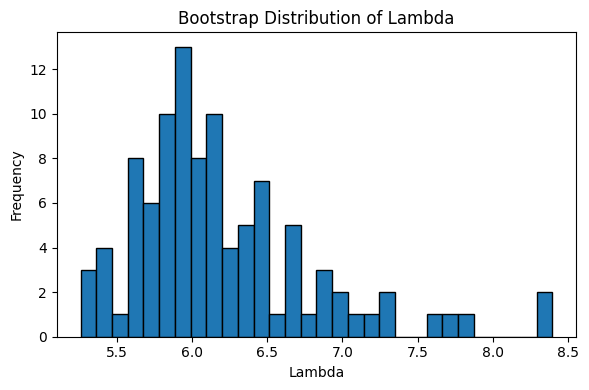

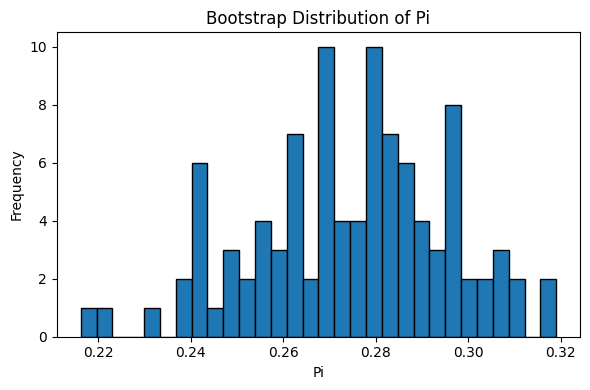

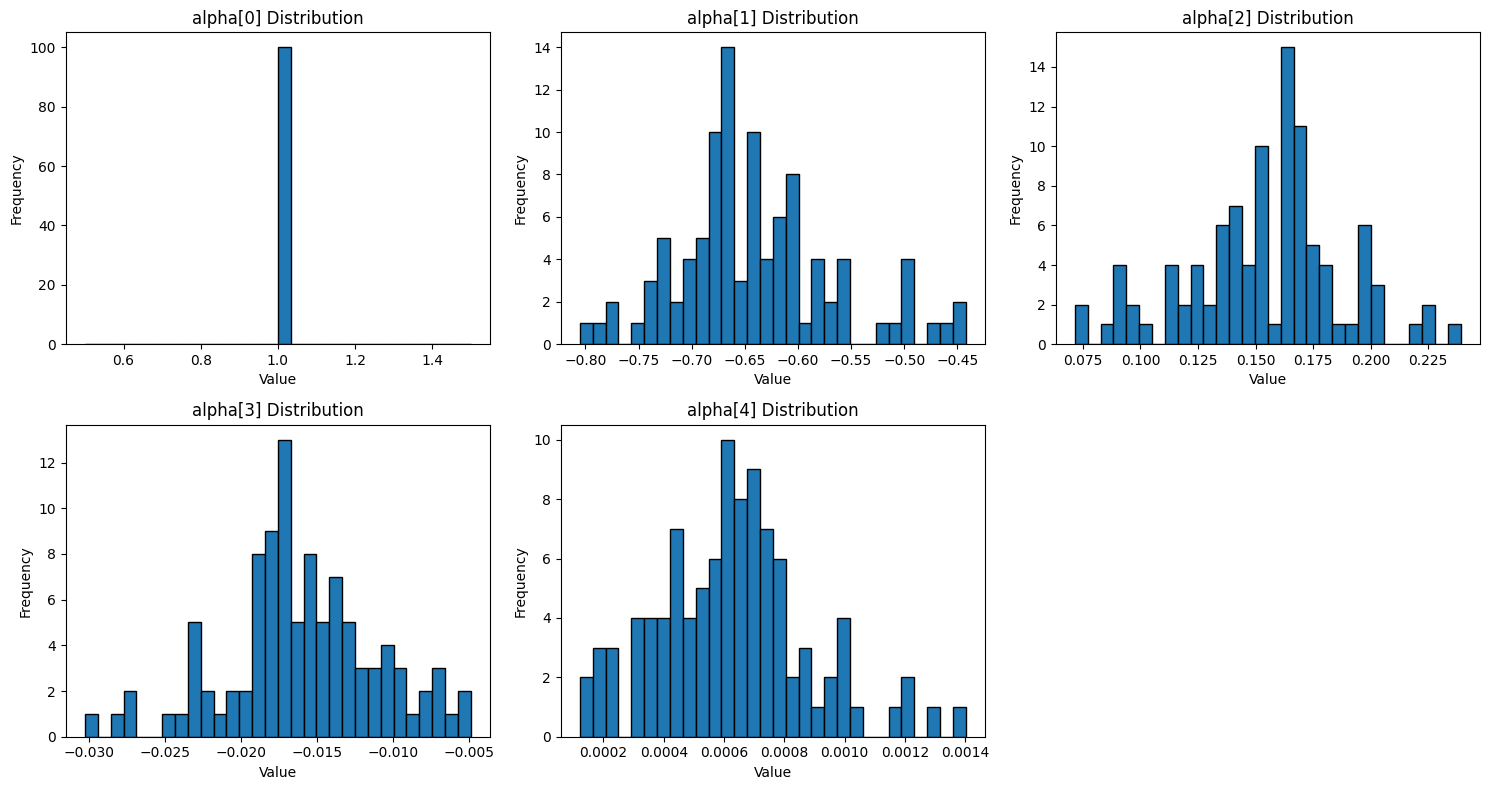

In [68]:
import math
import matplotlib.pyplot as plt

# result = bootstrap_zipap(y_all, 4, n_boot=100, random_seed=42)

# 1) 파라미터 꺼내기
lams   = boot_res100['lambda']          # shape = (100,)
pis    = boot_res100['pi']              # shape = (100,)
alphas = boot_res100['alpha']           # shape = (100, alpha_len)

# --- Lambda 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(lams, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Lambda')
plt.xlabel('Lambda')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Pi 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(pis, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Alpha 컴포넌트별 히스토그램 ---
num_alpha = alphas.shape[1]
ncols     = 3
nrows     = math.ceil(num_alpha / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axs = axs.flatten()

for j in range(num_alpha):
    ax = axs[j]
    ax.hist(alphas[:, j], bins=30, edgecolor='black')
    ax.set_title(f'alpha[{j}] Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# 남은 subplot 숨기기
for k in range(num_alpha, len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

In [17]:
def save_bootstrap_results(result, n_boot):
    """
    Save bootstrap results to a .npz file.
    
    Parameters
    ----------
    result : dict
        Dictionary containing 'lambda', 'pi', and 'alpha' arrays.
    """
    np.savez(f'bootstrap_results{n_boot}.npz', 
             lambda_vals=result['lambda'], 
             pi_vals=result['pi'], 
             alpha_vals=result['alpha'])
    

In [46]:
# 100번 부트스트랩 생성
save_bootstrap_results(boot_res100, n_boot=100)

In [ ]:
loaded = np.load('bootstrap_results.npz')
lambda_loaded = loaded['lambda_vals']
pi_loaded = loaded['pi_vals']
alpha_loaded = loaded['alpha_vals']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 공분산 행렬을 DataFrame으로
cols = ['lambda', 'pi'] + [f'alpha_{i}' for i in range(cov_matrix.shape[0]-2)]
df_cov = pd.DataFrame(cov_matrix, index=cols, columns=cols)

# 2) 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(df_cov, annot=True, fmt='.2e', cmap='RdBu_r', center=0,
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Covariance Matrix Heatmap')
plt.tight_layout()
plt.show()


In [69]:
import numpy as np

lam_samps   = boot_res100['lambda']      # shape (1000,)
pi_samps    = boot_res100['pi']          # shape (1000,)
alpha_samps = boot_res100['alpha']       # shape (1000, L)

# λ 요약
lam_mean = np.mean(lam_samps)
lam_ci   = np.percentile(lam_samps, [2.5, 97.5])

# π 요약
pi_mean = np.mean(pi_samps)
pi_ci   = np.percentile(pi_samps, [2.5, 97.5])

# α 벡터 각 원소 요약 (예: 첫 두 원소)
alpha_mean = np.mean(alpha_samps, axis=0)
alpha_ci   = np.percentile(alpha_samps, [2.5, 97.5], axis=0)

print(f"λ    = {lam_mean:.4f}  (95%CI: {lam_ci[0]:.4f}–{lam_ci[1]:.4f})")
print(f"π    = {pi_mean:.4f}  (95%CI: {pi_ci[0]:.4f}–{pi_ci[1]:.4f})")
print("α 벡터 평균:", np.round(alpha_mean,4))
print("α 벡터 95%CI:", np.round(alpha_ci,4))

λ    = 6.1972  (95%CI: 5.3463–7.7613)
π    = 0.2744  (95%CI: 0.2351–0.3105)
α 벡터 평균: [ 1.000e+00 -6.408e-01  1.539e-01 -1.600e-02  6.000e-04]
α 벡터 95%CI: [[ 1.000e+00 -7.760e-01  8.600e-02 -2.710e-02  2.000e-04]
 [ 1.000e+00 -4.672e-01  2.224e-01 -6.500e-03  1.200e-03]]


In [70]:
## 커버리지 확률
import numpy as np

# (이미 부트스트랩으로 lam_samps, pi_samps, alpha_samps 와
# lam_ci, pi_ci, alpha_ci를 계산했다고 가정)

# 1) λ의 empirical coverage
lam_lower, lam_upper = lam_ci
lam_coverage = np.mean((lam_samps >= lam_lower) & (lam_samps <= lam_upper))
print(f"λ 커버리지: {lam_coverage:.3f}")  # ~0.95 근처일 것

# 2) π의 empirical coverage
pi_lower, pi_upper = pi_ci
pi_coverage = np.mean((pi_samps >= pi_lower) & (pi_samps <= pi_upper))
print(f"π 커버리지: {pi_coverage:.3f}")

# 3) α 벡터 각 원소별 coverage
alpha_lower = alpha_ci[0]  # shape (L,)
alpha_upper = alpha_ci[1]  # shape (L,)
alpha_coverage = np.mean(
    (alpha_samps >= alpha_lower) & (alpha_samps <= alpha_upper),
    axis=0
)
print("α 벡터 커버리지:", np.round(alpha_coverage,3))


λ 커버리지: 0.940
π 커버리지: 0.940
α 벡터 커버리지: [1.   0.94 0.94 0.94 0.94]


### 200번 부트스트랩

In [71]:

# 부트스트랩 실행 및 결과
boot_res200 = bootstrap_zipap(y_all, 4, n_boot=200, random_seed=42)
lam_samps = boot_res200['lambda']
pi_samps  = boot_res200['pi']
alpha_samps = boot_res200['alpha']

# 5) summary & covariance
param_samples = np.column_stack([lam_samps, pi_samps, alpha_samps])
cov_matrix    = np.cov(param_samples, rowvar=False)
print("Covariance matrix (bootstrap):")
print(cov_matrix)

Bootstrap iteration 1/200
  -> lambda=5.9764, pi=0.2434, alpha=[ 1.000e+00 -6.675e-01  1.627e-01 -1.690e-02  7.000e-04]
Bootstrap iteration 2/200
  -> lambda=5.6138, pi=0.2623, alpha=[ 1.000e+00 -6.968e-01  1.771e-01 -1.910e-02  8.000e-04]
Bootstrap iteration 3/200
  -> lambda=6.1589, pi=0.2709, alpha=[ 1.000e+00 -6.396e-01  1.501e-01 -1.500e-02  6.000e-04]
Bootstrap iteration 4/200
  -> lambda=7.7509, pi=0.3079, alpha=[ 1.000e+00 -5.016e-01  9.270e-02 -7.200e-03  2.000e-04]
Bootstrap iteration 5/200
  -> lambda=6.4793, pi=0.2795, alpha=[ 1.000e+00 -6.088e-01  1.381e-01 -1.340e-02  5.000e-04]
Bootstrap iteration 6/200
  -> lambda=5.6334, pi=0.2501, alpha=[ 1.000e+00 -7.277e-01  1.954e-01 -2.220e-02  9.000e-04]
Bootstrap iteration 7/200
  -> lambda=5.9932, pi=0.2615, alpha=[ 1.000e+00 -6.838e-01  1.706e-01 -1.800e-02  7.000e-04]
Bootstrap iteration 8/200
  -> lambda=5.8255, pi=0.2587, alpha=[ 1.000e+00 -6.700e-01  1.634e-01 -1.690e-02  6.000e-04]
Bootstrap iteration 9/200
  -> lambda=6.

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:41: RuntimeWarning: overflow encountered in power
  out += S(j,k)*lam**k


  -> lambda=6.2602, pi=0.2802, alpha=[ 1.000e+00 -6.472e-01  1.530e-01 -1.520e-02  6.000e-04]
Bootstrap iteration 72/200
  -> lambda=5.8310, pi=0.2725, alpha=[ 1.000e+00 -6.831e-01  1.734e-01 -1.880e-02  8.000e-04]
Bootstrap iteration 73/200
  -> lambda=5.9713, pi=0.2408, alpha=[ 1.000e+00 -6.915e-01  1.739e-01 -1.840e-02  7.000e-04]
Bootstrap iteration 74/200
  -> lambda=5.3959, pi=0.2785, alpha=[ 1.     -0.738   0.2056 -0.0251  0.0012]
Bootstrap iteration 75/200
  -> lambda=6.0709, pi=0.2547, alpha=[ 1.000e+00 -6.625e-01  1.610e-01 -1.660e-02  6.000e-04]
Bootstrap iteration 76/200
  -> lambda=5.3810, pi=0.2618, alpha=[ 1.     -0.7821  0.2235 -0.0272  0.0012]
Bootstrap iteration 77/200
  -> lambda=6.3102, pi=0.3012, alpha=[ 1.000e+00 -6.204e-01  1.436e-01 -1.430e-02  5.000e-04]
Bootstrap iteration 78/200
  -> lambda=6.1611, pi=0.3064, alpha=[ 1.000e+00 -6.451e-01  1.539e-01 -1.570e-02  6.000e-04]
Bootstrap iteration 79/200
  -> lambda=5.6040, pi=0.2499, alpha=[ 1.     -0.74    0.2002 

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:74: RuntimeWarning: overflow encountered in exp
  lam      = np.exp(loglam) # loglam 은 단일한 로그 Poisson rate 파라미터
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:81: RuntimeWarning: invalid value encountered in scalar add
  Z = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))
/Users/ijongseung/statistic/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:956: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu


  -> lambda=6.5748, pi=0.2863, alpha=[ 1.000e+00 -6.014e-01  1.312e-01 -1.220e-02  4.000e-04]
Bootstrap iteration 111/200
  -> lambda=8.1404, pi=0.3084, alpha=[ 1.000e+00 -4.721e-01  8.180e-02 -6.000e-03  2.000e-04]
Bootstrap iteration 112/200
  -> lambda=6.4330, pi=0.2680, alpha=[ 1.000e+00 -6.141e-01  1.350e-01 -1.240e-02  4.000e-04]
Bootstrap iteration 113/200
  -> lambda=6.1842, pi=0.2752, alpha=[ 1.000e+00 -6.355e-01  1.486e-01 -1.480e-02  5.000e-04]
Bootstrap iteration 114/200


/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:75: RuntimeWarning: overflow encountered in exp
  pi       = 1/(1+np.exp(-logit_pi)) # logit_pi 는 단일한 로그릿(zero‐inflation 확률) 파라미터


  -> lambda=5.8294, pi=0.3258, alpha=[ 1.000e+00 -6.780e-01  1.702e-01 -1.820e-02  7.000e-04]
Bootstrap iteration 115/200
  -> lambda=5.7114, pi=0.2883, alpha=[ 1.000e+00 -7.014e-01  1.836e-01 -2.060e-02  9.000e-04]
Bootstrap iteration 116/200
  -> lambda=5.7132, pi=0.2527, alpha=[ 1.000e+00 -6.923e-01  1.765e-01 -1.910e-02  8.000e-04]
Bootstrap iteration 117/200
  -> lambda=6.5566, pi=0.3055, alpha=[ 1.000e+00 -6.020e-01  1.339e-01 -1.280e-02  5.000e-04]
Bootstrap iteration 118/200
  -> lambda=5.8802, pi=0.3032, alpha=[ 1.000e+00 -6.933e-01  1.789e-01 -1.980e-02  8.000e-04]
Bootstrap iteration 119/200
  -> lambda=5.5173, pi=0.2469, alpha=[ 1.     -0.7134  0.1901 -0.022   0.001 ]
Bootstrap iteration 120/200
  -> lambda=7.5915, pi=0.2846, alpha=[ 1.000e+00 -4.905e-01  8.930e-02 -6.900e-03  2.000e-04]
Bootstrap iteration 121/200
  -> lambda=6.3923, pi=0.2635, alpha=[ 1.000e+00 -6.271e-01  1.452e-01 -1.420e-02  5.000e-04]
Bootstrap iteration 122/200
  -> lambda=6.1436, pi=0.2882, alpha=[ 

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 198.]),
 array([-1.13555621e+03, -1.02202837e+03, -9.08500527e+02, -7.94972686e+02,
        -6.81444845e+02, -5.67917003e+02, -4.54389162e+02, -3.40861320e+02,
        -2.27333479e+02, -1.13805638e+02, -2.77796392e-01]),
 <BarContainer object of 10 artists>)

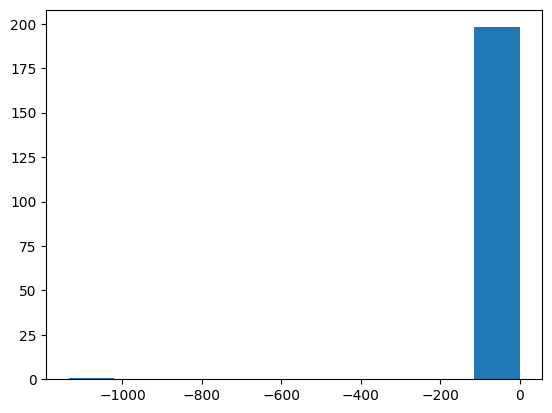

In [83]:
plt.hist(alphas[:, 1])

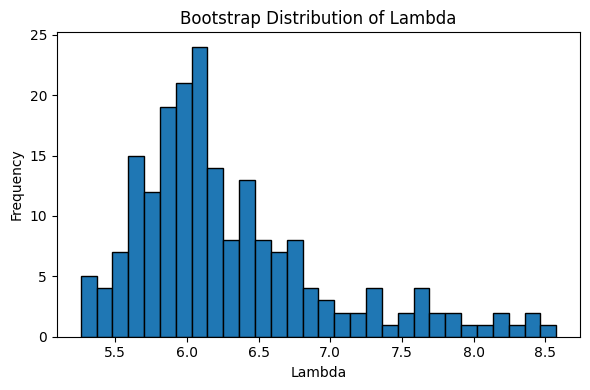

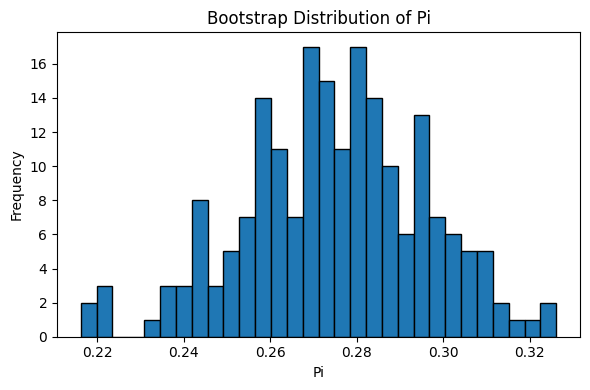

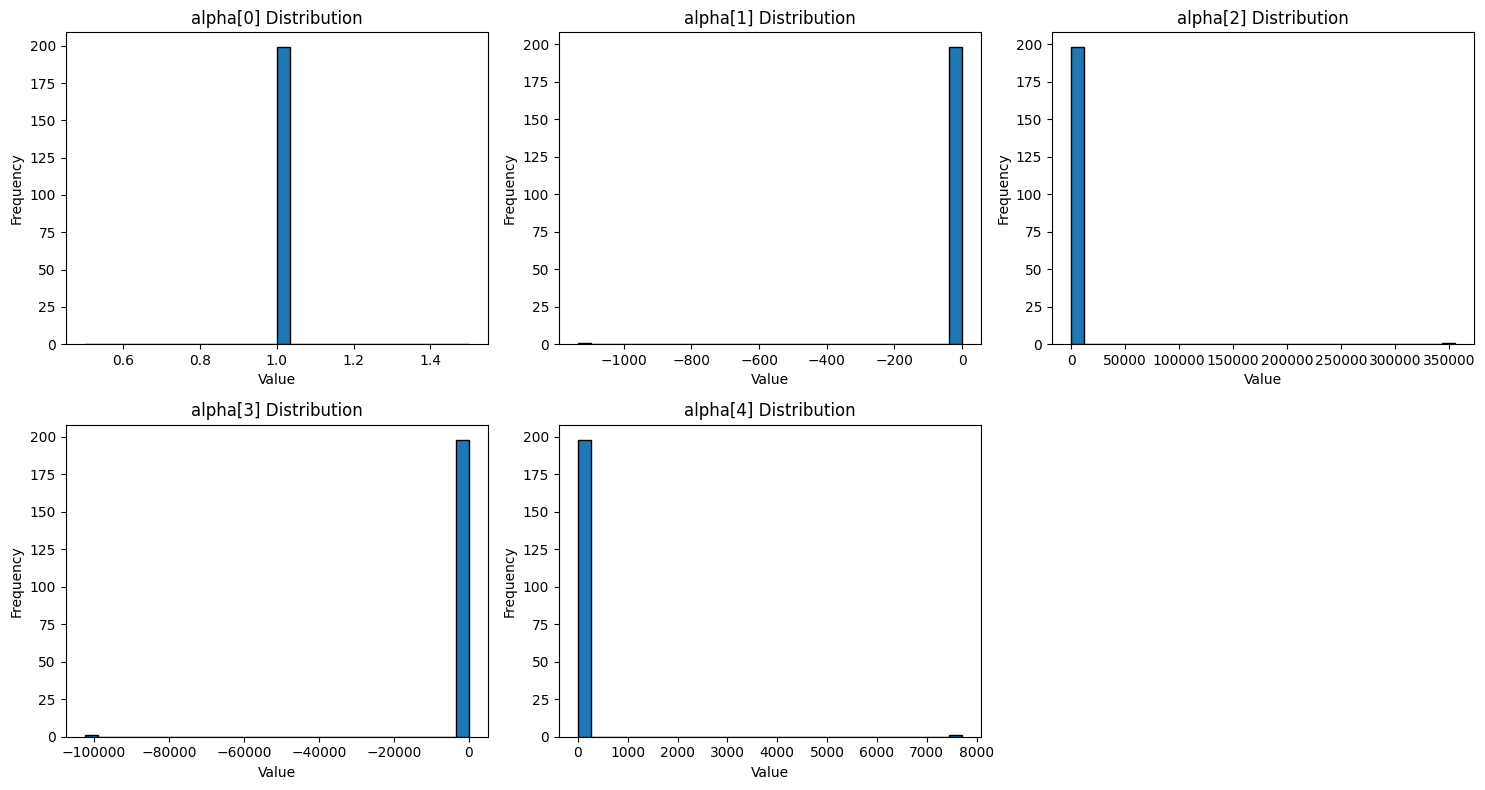

In [ ]:
# 1) 파라미터 꺼내기
lams   = boot_res200['lambda']          # shape = (100,)
pis    = boot_res200['pi']              # shape = (100,)
alphas = boot_res200['alpha']           # shape = (100, alpha_len)

# --- Lambda 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(lams, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Lambda')
plt.xlabel('Lambda')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Pi 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(pis, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Alpha 컴포넌트별 히스토그램 ---
num_alpha = alphas.shape[1]
ncols     = 3
nrows     = math.ceil(num_alpha / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axs = axs.flatten()

for j in range(num_alpha):
    ax = axs[j]
    ax.hist(alphas[:, j], bins=30, edgecolor='black')
    ax.set_title(f'alpha[{j}] Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# 남은 subplot 숨기기
for k in range(num_alpha, len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

In [76]:
import numpy as np

lam_samps   = boot_res200['lambda']      # shape (1000,)
pi_samps    = boot_res200['pi']          # shape (1000,)
alpha_samps = boot_res200['alpha']       # shape (1000, L)

# λ 요약
lam_mean = np.mean(lam_samps)
lam_ci   = np.percentile(lam_samps, [2.5, 97.5])

# π 요약
pi_mean = np.mean(pi_samps)
pi_ci   = np.percentile(pi_samps, [2.5, 97.5])

# α 벡터 각 원소 요약 (예: 첫 두 원소)
alpha_mean = np.mean(alpha_samps, axis=0)
alpha_ci   = np.percentile(alpha_samps, [2.5, 97.5], axis=0)

print(f"λ    = {lam_mean:.4f}  (95%CI: {lam_ci[0]:.4f}–{lam_ci[1]:.4f})")
print(f"π    = {pi_mean:.4f}  (95%CI: {pi_ci[0]:.4f}–{pi_ci[1]:.4f})")
print("α 벡터 평균:", np.round(alpha_mean,4))
print("α 벡터 95%CI:", np.round(alpha_ci,4))

λ    = 6.2975  (95%CI: 5.3777–8.1415)
π    = 0.2747  (95%CI: 0.2322–0.3134)
α 벡터 평균: [ 1.0000000e+00 -6.3307000e+00  1.7878139e+03 -5.1488250e+02
  3.8728500e+01]
α 벡터 95%CI: [[ 1.000e+00 -7.695e-01  7.260e-02 -2.610e-02  1.000e-04]
 [ 1.000e+00 -4.451e-01  2.168e-01 -4.900e-03  1.200e-03]]


In [77]:
## 커버리지 확률
import numpy as np

# (이미 부트스트랩으로 lam_samps, pi_samps, alpha_samps 와
# lam_ci, pi_ci, alpha_ci를 계산했다고 가정)

# 1) λ의 empirical coverage
lam_lower, lam_upper = lam_ci
lam_coverage = np.mean((lam_samps >= lam_lower) & (lam_samps <= lam_upper))
print(f"λ 커버리지: {lam_coverage:.5f}")  # ~0.95 근처일 것

# 2) π의 empirical coverage
pi_lower, pi_upper = pi_ci
pi_coverage = np.mean((pi_samps >= pi_lower) & (pi_samps <= pi_upper))
print(f"π 커버리지: {pi_coverage:.5f}")

# 3) α 벡터 각 원소별 coverage
alpha_lower = alpha_ci[0]  # shape (L,)
alpha_upper = alpha_ci[1]  # shape (L,)
alpha_coverage = np.mean(
    (alpha_samps >= alpha_lower) & (alpha_samps <= alpha_upper),
    axis=0
)
print("α 벡터 커버리지:", np.round(alpha_coverage,3))


λ 커버리지: 0.94975
π 커버리지: 0.94975
α 벡터 커버리지: [1.   0.95 0.95 0.95 0.95]


### 300번

In [78]:
result200 = bootstrap_zipap(y_all, 4, n_boot=300, random_seed=42)

Bootstrap iteration 1/300
  -> lambda=5.9764, pi=0.2434, alpha=[ 1.000e+00 -6.675e-01  1.627e-01 -1.690e-02  7.000e-04]
Bootstrap iteration 2/300
  -> lambda=5.6138, pi=0.2623, alpha=[ 1.000e+00 -6.968e-01  1.771e-01 -1.910e-02  8.000e-04]
Bootstrap iteration 3/300
  -> lambda=6.1589, pi=0.2709, alpha=[ 1.000e+00 -6.396e-01  1.501e-01 -1.500e-02  6.000e-04]
Bootstrap iteration 4/300
  -> lambda=7.7509, pi=0.3079, alpha=[ 1.000e+00 -5.016e-01  9.270e-02 -7.200e-03  2.000e-04]
Bootstrap iteration 5/300
  -> lambda=6.4793, pi=0.2795, alpha=[ 1.000e+00 -6.088e-01  1.381e-01 -1.340e-02  5.000e-04]
Bootstrap iteration 6/300
  -> lambda=5.6334, pi=0.2501, alpha=[ 1.000e+00 -7.277e-01  1.954e-01 -2.220e-02  9.000e-04]
Bootstrap iteration 7/300
  -> lambda=5.9932, pi=0.2615, alpha=[ 1.000e+00 -6.838e-01  1.706e-01 -1.800e-02  7.000e-04]
Bootstrap iteration 8/300
  -> lambda=5.8255, pi=0.2587, alpha=[ 1.000e+00 -6.700e-01  1.634e-01 -1.690e-02  6.000e-04]
Bootstrap iteration 9/300
  -> lambda=6.

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:41: RuntimeWarning: overflow encountered in power
  out += S(j,k)*lam**k


  -> lambda=6.2602, pi=0.2802, alpha=[ 1.000e+00 -6.472e-01  1.530e-01 -1.520e-02  6.000e-04]
Bootstrap iteration 72/300
  -> lambda=5.8310, pi=0.2725, alpha=[ 1.000e+00 -6.831e-01  1.734e-01 -1.880e-02  8.000e-04]
Bootstrap iteration 73/300
  -> lambda=5.9713, pi=0.2408, alpha=[ 1.000e+00 -6.915e-01  1.739e-01 -1.840e-02  7.000e-04]
Bootstrap iteration 74/300
  -> lambda=5.3959, pi=0.2785, alpha=[ 1.     -0.738   0.2056 -0.0251  0.0012]
Bootstrap iteration 75/300
  -> lambda=6.0709, pi=0.2547, alpha=[ 1.000e+00 -6.625e-01  1.610e-01 -1.660e-02  6.000e-04]
Bootstrap iteration 76/300
  -> lambda=5.3810, pi=0.2618, alpha=[ 1.     -0.7821  0.2235 -0.0272  0.0012]
Bootstrap iteration 77/300
  -> lambda=6.3102, pi=0.3012, alpha=[ 1.000e+00 -6.204e-01  1.436e-01 -1.430e-02  5.000e-04]
Bootstrap iteration 78/300
  -> lambda=6.1611, pi=0.3064, alpha=[ 1.000e+00 -6.451e-01  1.539e-01 -1.570e-02  6.000e-04]
Bootstrap iteration 79/300
  -> lambda=5.6040, pi=0.2499, alpha=[ 1.     -0.74    0.2002 

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:74: RuntimeWarning: overflow encountered in exp
  lam      = np.exp(loglam) # loglam 은 단일한 로그 Poisson rate 파라미터
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:81: RuntimeWarning: invalid value encountered in scalar add
  Z = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))


  -> lambda=6.5748, pi=0.2863, alpha=[ 1.000e+00 -6.014e-01  1.312e-01 -1.220e-02  4.000e-04]
Bootstrap iteration 111/300
  -> lambda=8.1404, pi=0.3084, alpha=[ 1.000e+00 -4.721e-01  8.180e-02 -6.000e-03  2.000e-04]
Bootstrap iteration 112/300
  -> lambda=6.4330, pi=0.2680, alpha=[ 1.000e+00 -6.141e-01  1.350e-01 -1.240e-02  4.000e-04]
Bootstrap iteration 113/300
  -> lambda=6.1842, pi=0.2752, alpha=[ 1.000e+00 -6.355e-01  1.486e-01 -1.480e-02  5.000e-04]
Bootstrap iteration 114/300


/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:75: RuntimeWarning: overflow encountered in exp
  pi       = 1/(1+np.exp(-logit_pi)) # logit_pi 는 단일한 로그릿(zero‐inflation 확률) 파라미터


  -> lambda=5.8294, pi=0.3258, alpha=[ 1.000e+00 -6.780e-01  1.702e-01 -1.820e-02  7.000e-04]
Bootstrap iteration 115/300
  -> lambda=5.7114, pi=0.2883, alpha=[ 1.000e+00 -7.014e-01  1.836e-01 -2.060e-02  9.000e-04]
Bootstrap iteration 116/300
  -> lambda=5.7132, pi=0.2527, alpha=[ 1.000e+00 -6.923e-01  1.765e-01 -1.910e-02  8.000e-04]
Bootstrap iteration 117/300
  -> lambda=6.5566, pi=0.3055, alpha=[ 1.000e+00 -6.020e-01  1.339e-01 -1.280e-02  5.000e-04]
Bootstrap iteration 118/300
  -> lambda=5.8802, pi=0.3032, alpha=[ 1.000e+00 -6.933e-01  1.789e-01 -1.980e-02  8.000e-04]
Bootstrap iteration 119/300
  -> lambda=5.5173, pi=0.2469, alpha=[ 1.     -0.7134  0.1901 -0.022   0.001 ]
Bootstrap iteration 120/300
  -> lambda=7.5915, pi=0.2846, alpha=[ 1.000e+00 -4.905e-01  8.930e-02 -6.900e-03  2.000e-04]
Bootstrap iteration 121/300
  -> lambda=6.3923, pi=0.2635, alpha=[ 1.000e+00 -6.271e-01  1.452e-01 -1.420e-02  5.000e-04]
Bootstrap iteration 122/300
  -> lambda=6.1436, pi=0.2882, alpha=[ 

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:37: RuntimeWarning: overflow encountered in square
  if j==2: return lam**2 + lam
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:38: RuntimeWarning: overflow encountered in power
  if j==3: return lam**3 + 3*lam**2 + lam
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:38: RuntimeWarning: overflow encountered in square
  if j==3: return lam**3 + 3*lam**2 + lam
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:41: RuntimeWarning: overflow encountered in square
  out += S(j,k)*lam**k


  -> lambda=7.3012, pi=0.2553, alpha=[ 1.000e+00 -4.944e-01  8.940e-02 -6.800e-03  2.000e-04]
Bootstrap iteration 209/300
  -> lambda=5.8373, pi=0.3016, alpha=[ 1.000e+00 -5.683e-01  1.327e-01 -1.480e-02  7.000e-04]
Bootstrap iteration 210/300
  -> lambda=6.6462, pi=0.2899, alpha=[ 1.000e+00 -5.527e-01  1.129e-01 -9.900e-03  3.000e-04]
Bootstrap iteration 211/300
  -> lambda=6.1490, pi=0.2892, alpha=[ 1.000e+00 -6.347e-01  1.465e-01 -1.430e-02  5.000e-04]
Bootstrap iteration 212/300
  -> lambda=5.9646, pi=0.2926, alpha=[ 1.000e+00 -6.765e-01  1.668e-01 -1.740e-02  7.000e-04]
Bootstrap iteration 213/300
  -> lambda=6.4819, pi=0.2757, alpha=[ 1.000e+00 -5.949e-01  1.300e-01 -1.220e-02  4.000e-04]
Bootstrap iteration 214/300
  -> lambda=5.7220, pi=0.2647, alpha=[ 1.000e+00 -7.060e-01  1.822e-01 -2.000e-02  8.000e-04]
Bootstrap iteration 215/300
  -> lambda=5.6360, pi=0.2861, alpha=[ 1.000e+00 -6.985e-01  1.859e-01 -2.160e-02  9.000e-04]
Bootstrap iteration 216/300
  -> lambda=7.1851, pi=0

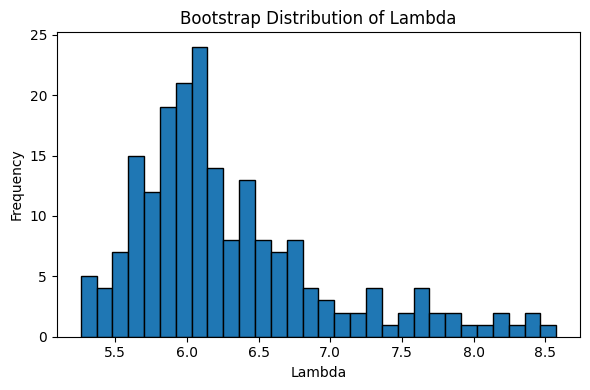

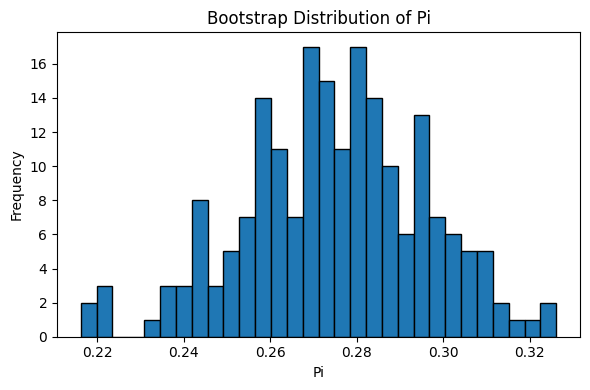

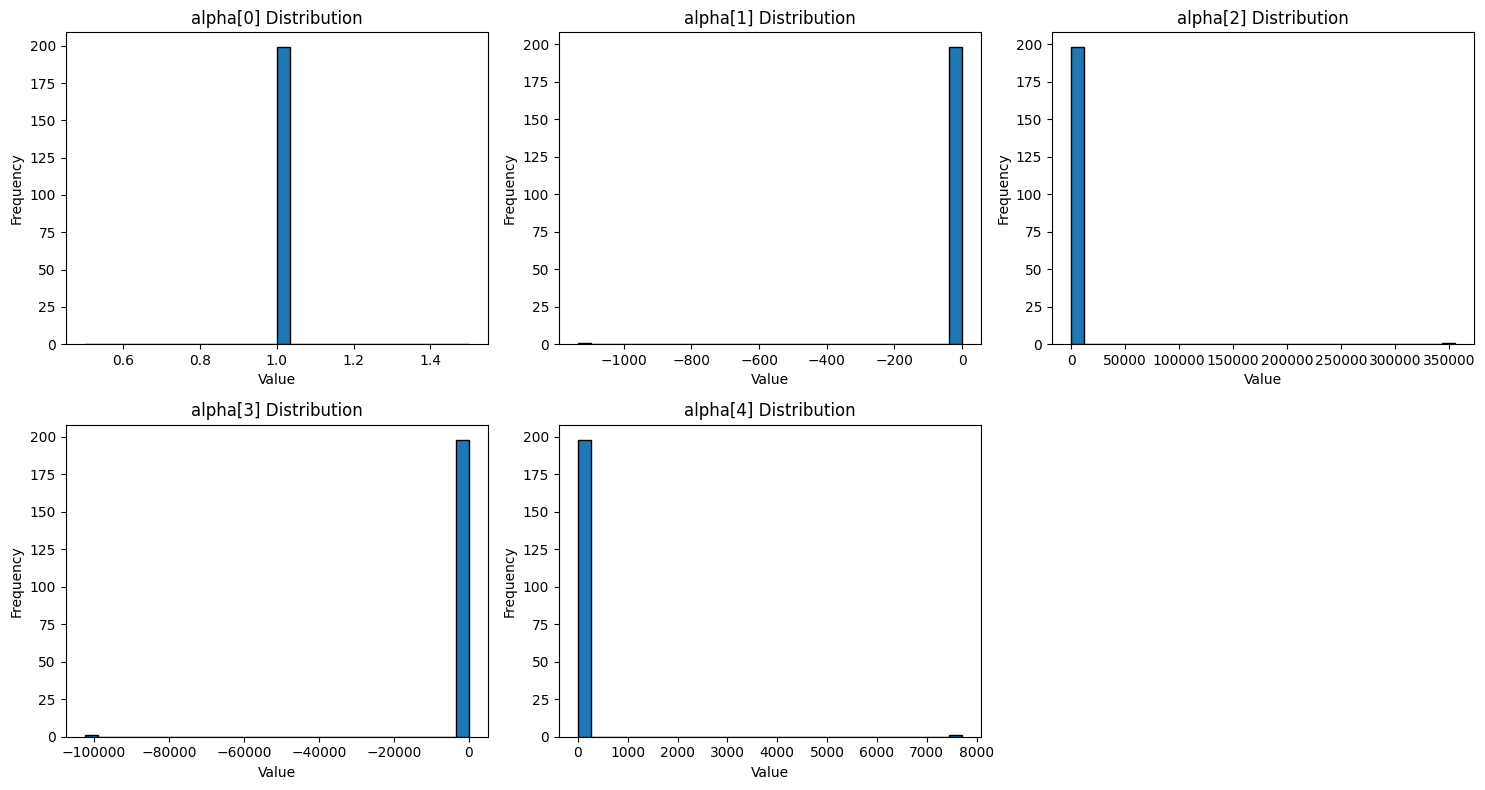

In [79]:
# 1) 파라미터 꺼내기
lams   = boot_res200['lambda']          # shape = (100,)
pis    = boot_res200['pi']              # shape = (100,)
alphas = boot_res200['alpha']           # shape = (100, alpha_len)

# --- Lambda 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(lams, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Lambda')
plt.xlabel('Lambda')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Pi 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(pis, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Alpha 컴포넌트별 히스토그램 ---
num_alpha = alphas.shape[1]
ncols     = 3
nrows     = math.ceil(num_alpha / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axs = axs.flatten()

for j in range(num_alpha):
    ax = axs[j]
    ax.hist(alphas[:, j], bins=30, edgecolor='black')
    ax.set_title(f'alpha[{j}] Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# 남은 subplot 숨기기
for k in range(num_alpha, len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

### 새 로직을 구성하여 부트스트래핑 한 코드

In [87]:
import numpy as np

def bootstrap_zipap_until_success(y, degree, n_boot=200, random_seed=None,
                                 alpha_thresh=1e3, max_tries=1000):
    """
    부트스트랩을 시도하되, 성공한 샘플이 n_boot이 될 때까지 반복합니다.

    Parameters
    ----------
    y : array-like
        원본 데이터.
    degree : int
        ZIPAP 차수.
    n_boot : int
        최종적으로 모을 성공 샘플 수.
    random_seed : int or None
        재현용 시드. None이면 매 실행마다 다른 시퀀스를 사용합니다.
    alpha_thresh : float
        α 벡터 폭주 필터 임계값.
    max_tries : int
        최대 시도 횟수 (성공+실패 합).

    Returns
    -------
    dict
        {
          'lambda': np.ndarray,
          'pi': np.ndarray,
          'alpha': np.ndarray,
          'success_count': int,
          'tries': int
        }
    """
    # 시드 설정: None인 경우 자동 랜덤 시드
    rng = np.random.RandomState(random_seed) if random_seed is not None else np.random.RandomState()

    n = len(y)
    r0 = degree // 2
    r1 = (degree - 1) // 2 if degree > 0 else -1
    alpha_len = max(2 * r0, 1 + 2 * r1) + 1

    lam_list, pi_list, alpha_list = [], [], []
    tries = 0

    while len(lam_list) < n_boot and tries < max_tries:
        tries += 1
        yb = rng.choice(y, size=n, replace=True)
        model = ZIPAP(degree=degree, y=yb)
        try:
            res = model.fit()
            # θ 안정성 체크
            if not res.success or np.any(np.isnan(res.x)) or np.any(np.abs(res.x) > 1e3):
                print(f"Try {tries}: θ invalid, skipping")
                continue

            # 파라미터 역변환
            lam_i = np.exp(res.x[0])
            pi_i  = 1 / (1 + np.exp(-res.x[-1]))
            u1 = res.x[1:1 + r0]
            v  = res.x[1 + r0:1 + r0 + (r1 + 1)]
            # α 계산 및 안정성 체크
            alpha_i = compute_alpha(np.concatenate(([1.0], u1)), v)
            if np.any(np.abs(alpha_i) > alpha_thresh):
                print(f"Try {tries}: α exploded (max|α|={np.max(np.abs(alpha_i)):.1f}), skipping")
                continue

            # 성공 저장 및 로그
            lam_list.append(lam_i)
            pi_list.append(pi_i)
            alpha_list.append(alpha_i)
            idx = len(lam_list)
            print(f"Success {idx}/{n_boot} (Try {tries}): λ={lam_i:.4f}, π={pi_i:.4f}, α={np.round(alpha_i,4)}")

        except RuntimeError:
            print(f"Try {tries}: optimization failed, skipping")

    print(f"\n✅ Collected {len(lam_list)}/{n_boot} samples in {tries} tries")
    return {
        'lambda':   np.array(lam_list),
        'pi':       np.array(pi_list),
        'alpha':    np.vstack(alpha_list) if alpha_list else np.empty((0, alpha_len)),
        'success_count': len(lam_list),
        'tries':    tries
    }



#### 100번

In [91]:
result1_100 = bootstrap_zipap_until_success(y_all, 4, n_boot=100, random_seed=42,
                                 alpha_thresh=1e3, max_tries=1000) # y_all, 4, n_boot=300

Success 1/100 (Try 1): λ=5.9764, π=0.2434, α=[ 1.000e+00 -6.675e-01  1.627e-01 -1.690e-02  7.000e-04]
Success 2/100 (Try 2): λ=5.6138, π=0.2623, α=[ 1.000e+00 -6.968e-01  1.771e-01 -1.910e-02  8.000e-04]
Success 3/100 (Try 3): λ=6.1589, π=0.2709, α=[ 1.000e+00 -6.396e-01  1.501e-01 -1.500e-02  6.000e-04]
Success 4/100 (Try 4): λ=7.7509, π=0.3079, α=[ 1.000e+00 -5.016e-01  9.270e-02 -7.200e-03  2.000e-04]
Success 5/100 (Try 5): λ=6.4793, π=0.2795, α=[ 1.000e+00 -6.088e-01  1.381e-01 -1.340e-02  5.000e-04]
Success 6/100 (Try 6): λ=5.6334, π=0.2501, α=[ 1.000e+00 -7.277e-01  1.954e-01 -2.220e-02  9.000e-04]
Success 7/100 (Try 7): λ=5.9932, π=0.2615, α=[ 1.000e+00 -6.838e-01  1.706e-01 -1.800e-02  7.000e-04]
Success 8/100 (Try 8): λ=5.8255, π=0.2587, α=[ 1.000e+00 -6.700e-01  1.634e-01 -1.690e-02  6.000e-04]
Success 9/100 (Try 9): λ=6.1041, π=0.2676, α=[ 1.000e+00 -6.289e-01  1.501e-01 -1.560e-02  6.000e-04]
Success 10/100 (Try 10): λ=6.2006, π=0.2870, α=[ 1.000e+00 -6.046e-01  1.369e-01 -

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:41: RuntimeWarning: overflow encountered in power
  out += S(j,k)*lam**k


Success 71/100 (Try 71): λ=6.2602, π=0.2802, α=[ 1.000e+00 -6.472e-01  1.530e-01 -1.520e-02  6.000e-04]
Success 72/100 (Try 72): λ=5.8310, π=0.2725, α=[ 1.000e+00 -6.831e-01  1.734e-01 -1.880e-02  8.000e-04]
Success 73/100 (Try 73): λ=5.9713, π=0.2408, α=[ 1.000e+00 -6.915e-01  1.739e-01 -1.840e-02  7.000e-04]
Success 74/100 (Try 74): λ=5.3959, π=0.2785, α=[ 1.     -0.738   0.2056 -0.0251  0.0012]
Success 75/100 (Try 75): λ=6.0709, π=0.2547, α=[ 1.000e+00 -6.625e-01  1.610e-01 -1.660e-02  6.000e-04]
Success 76/100 (Try 76): λ=5.3810, π=0.2618, α=[ 1.     -0.7821  0.2235 -0.0272  0.0012]
Success 77/100 (Try 77): λ=6.3102, π=0.3012, α=[ 1.000e+00 -6.204e-01  1.436e-01 -1.430e-02  5.000e-04]
Success 78/100 (Try 78): λ=6.1611, π=0.3064, α=[ 1.000e+00 -6.451e-01  1.539e-01 -1.570e-02  6.000e-04]
Success 79/100 (Try 79): λ=5.6040, π=0.2499, α=[ 1.     -0.74    0.2002 -0.0229  0.001 ]
Success 80/100 (Try 80): λ=5.9626, π=0.2694, α=[ 1.000e+00 -6.762e-01  1.681e-01 -1.780e-02  7.000e-04]
Succe

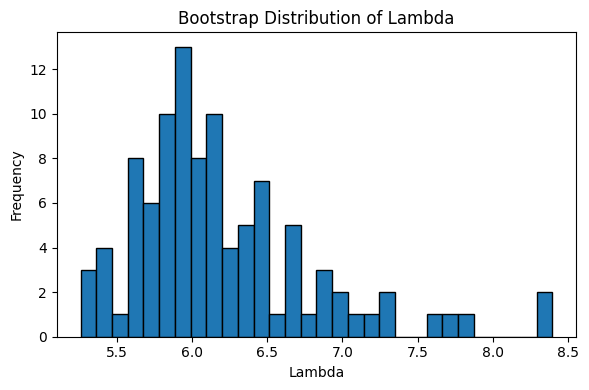

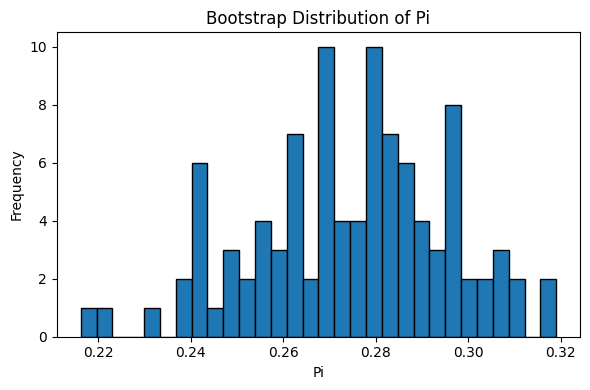

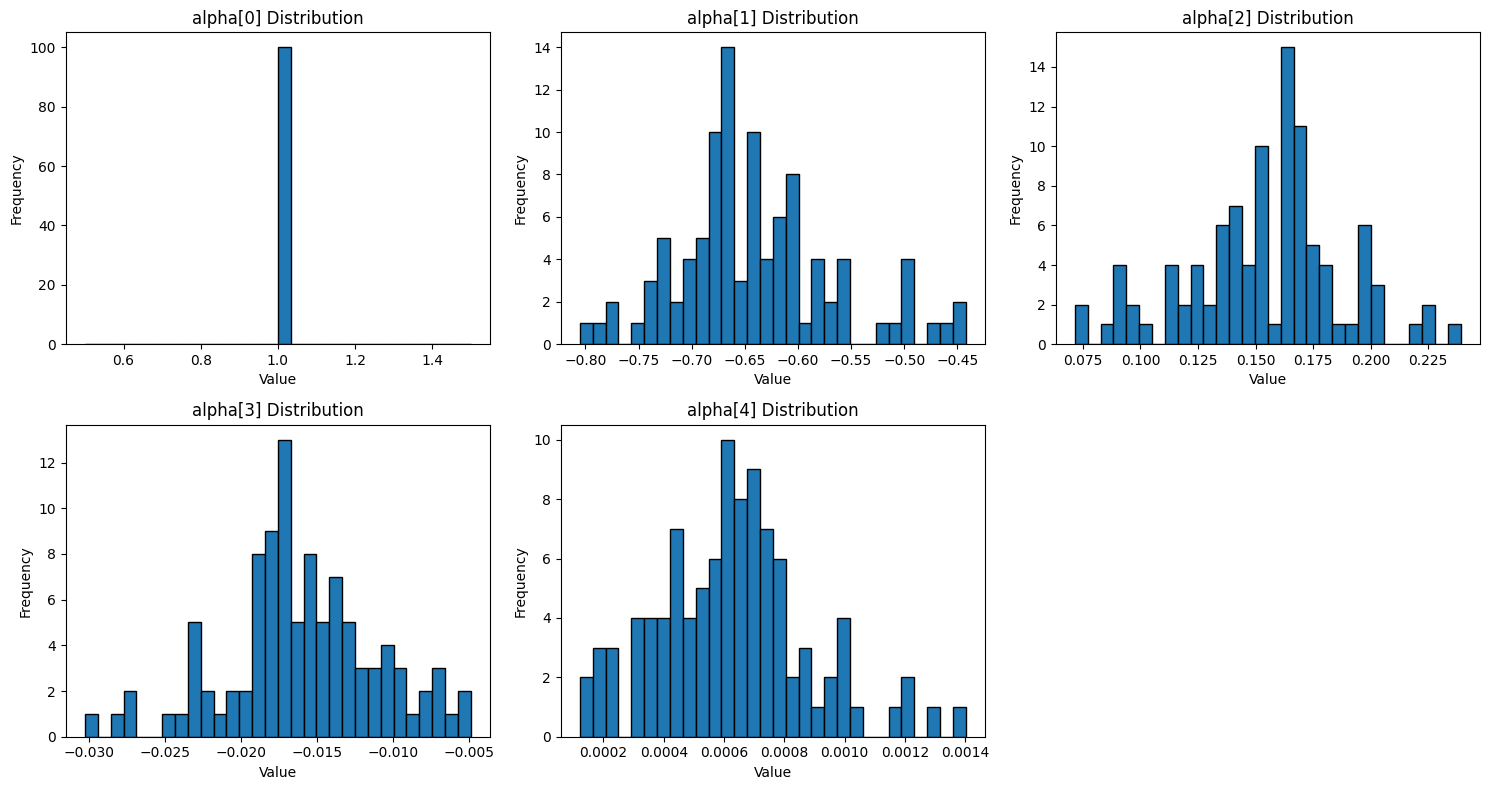

In [92]:
lams   = result1_100['lambda']          # shape = (100,)
pis    = result1_100['pi']              # shape = (100,)
alphas = result1_100['alpha']           # shape = (100, alpha_len)

# --- Lambda 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(lams, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Lambda')
plt.xlabel('Lambda')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Pi 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(pis, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Alpha 컴포넌트별 히스토그램 ---
num_alpha = alphas.shape[1]
ncols     = 3
nrows     = math.ceil(num_alpha / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axs = axs.flatten()

for j in range(num_alpha):
    ax = axs[j]
    ax.hist(alphas[:, j], bins=30, edgecolor='black')
    ax.set_title(f'alpha[{j}] Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# 남은 subplot 숨기기
for k in range(num_alpha, len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

#### 300번

In [89]:
result1_300 = bootstrap_zipap_until_success(y_all, 4, n_boot=300, random_seed=42,
                                 alpha_thresh=1e3, max_tries=1000) # y_all, 4, n_boot=300

Success 1/300 (Try 1): λ=5.9764, π=0.2434, α=[ 1.000e+00 -6.675e-01  1.627e-01 -1.690e-02  7.000e-04]
Success 2/300 (Try 2): λ=5.6138, π=0.2623, α=[ 1.000e+00 -6.968e-01  1.771e-01 -1.910e-02  8.000e-04]
Success 3/300 (Try 3): λ=6.1589, π=0.2709, α=[ 1.000e+00 -6.396e-01  1.501e-01 -1.500e-02  6.000e-04]
Success 4/300 (Try 4): λ=7.7509, π=0.3079, α=[ 1.000e+00 -5.016e-01  9.270e-02 -7.200e-03  2.000e-04]
Success 5/300 (Try 5): λ=6.4793, π=0.2795, α=[ 1.000e+00 -6.088e-01  1.381e-01 -1.340e-02  5.000e-04]
Success 6/300 (Try 6): λ=5.6334, π=0.2501, α=[ 1.000e+00 -7.277e-01  1.954e-01 -2.220e-02  9.000e-04]
Success 7/300 (Try 7): λ=5.9932, π=0.2615, α=[ 1.000e+00 -6.838e-01  1.706e-01 -1.800e-02  7.000e-04]
Success 8/300 (Try 8): λ=5.8255, π=0.2587, α=[ 1.000e+00 -6.700e-01  1.634e-01 -1.690e-02  6.000e-04]
Success 9/300 (Try 9): λ=6.1041, π=0.2676, α=[ 1.000e+00 -6.289e-01  1.501e-01 -1.560e-02  6.000e-04]
Success 10/300 (Try 10): λ=6.2006, π=0.2870, α=[ 1.000e+00 -6.046e-01  1.369e-01 -

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:41: RuntimeWarning: overflow encountered in power
  out += S(j,k)*lam**k


Success 71/300 (Try 71): λ=6.2602, π=0.2802, α=[ 1.000e+00 -6.472e-01  1.530e-01 -1.520e-02  6.000e-04]
Success 72/300 (Try 72): λ=5.8310, π=0.2725, α=[ 1.000e+00 -6.831e-01  1.734e-01 -1.880e-02  8.000e-04]
Success 73/300 (Try 73): λ=5.9713, π=0.2408, α=[ 1.000e+00 -6.915e-01  1.739e-01 -1.840e-02  7.000e-04]
Success 74/300 (Try 74): λ=5.3959, π=0.2785, α=[ 1.     -0.738   0.2056 -0.0251  0.0012]
Success 75/300 (Try 75): λ=6.0709, π=0.2547, α=[ 1.000e+00 -6.625e-01  1.610e-01 -1.660e-02  6.000e-04]
Success 76/300 (Try 76): λ=5.3810, π=0.2618, α=[ 1.     -0.7821  0.2235 -0.0272  0.0012]
Success 77/300 (Try 77): λ=6.3102, π=0.3012, α=[ 1.000e+00 -6.204e-01  1.436e-01 -1.430e-02  5.000e-04]
Success 78/300 (Try 78): λ=6.1611, π=0.3064, α=[ 1.000e+00 -6.451e-01  1.539e-01 -1.570e-02  6.000e-04]
Success 79/300 (Try 79): λ=5.6040, π=0.2499, α=[ 1.     -0.74    0.2002 -0.0229  0.001 ]
Success 80/300 (Try 80): λ=5.9626, π=0.2694, α=[ 1.000e+00 -6.762e-01  1.681e-01 -1.780e-02  7.000e-04]
Succe

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:74: RuntimeWarning: overflow encountered in exp
  lam      = np.exp(loglam) # loglam 은 단일한 로그 Poisson rate 파라미터
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:81: RuntimeWarning: invalid value encountered in scalar add
  Z = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))
/Users/ijongseung/statistic/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:956: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu


Success 110/300 (Try 110): λ=6.5748, π=0.2863, α=[ 1.000e+00 -6.014e-01  1.312e-01 -1.220e-02  4.000e-04]
Success 111/300 (Try 111): λ=8.1404, π=0.3084, α=[ 1.000e+00 -4.721e-01  8.180e-02 -6.000e-03  2.000e-04]
Success 112/300 (Try 112): λ=6.4330, π=0.2680, α=[ 1.000e+00 -6.141e-01  1.350e-01 -1.240e-02  4.000e-04]
Success 113/300 (Try 113): λ=6.1842, π=0.2752, α=[ 1.000e+00 -6.355e-01  1.486e-01 -1.480e-02  5.000e-04]


/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:75: RuntimeWarning: overflow encountered in exp
  pi       = 1/(1+np.exp(-logit_pi)) # logit_pi 는 단일한 로그릿(zero‐inflation 확률) 파라미터


Success 114/300 (Try 114): λ=5.8294, π=0.3258, α=[ 1.000e+00 -6.780e-01  1.702e-01 -1.820e-02  7.000e-04]
Success 115/300 (Try 115): λ=5.7114, π=0.2883, α=[ 1.000e+00 -7.014e-01  1.836e-01 -2.060e-02  9.000e-04]
Success 116/300 (Try 116): λ=5.7132, π=0.2527, α=[ 1.000e+00 -6.923e-01  1.765e-01 -1.910e-02  8.000e-04]
Success 117/300 (Try 117): λ=6.5566, π=0.3055, α=[ 1.000e+00 -6.020e-01  1.339e-01 -1.280e-02  5.000e-04]
Success 118/300 (Try 118): λ=5.8802, π=0.3032, α=[ 1.000e+00 -6.933e-01  1.789e-01 -1.980e-02  8.000e-04]
Success 119/300 (Try 119): λ=5.5173, π=0.2469, α=[ 1.     -0.7134  0.1901 -0.022   0.001 ]
Success 120/300 (Try 120): λ=7.5915, π=0.2846, α=[ 1.000e+00 -4.905e-01  8.930e-02 -6.900e-03  2.000e-04]
Success 121/300 (Try 121): λ=6.3923, π=0.2635, α=[ 1.000e+00 -6.271e-01  1.452e-01 -1.420e-02  5.000e-04]
Success 122/300 (Try 122): λ=6.1436, π=0.2882, α=[ 1.000e+00 -6.387e-01  1.512e-01 -1.540e-02  6.000e-04]
Success 123/300 (Try 123): λ=8.0535, π=0.2799, α=[ 1.000e+00 

/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:37: RuntimeWarning: overflow encountered in square
  if j==2: return lam**2 + lam
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:38: RuntimeWarning: overflow encountered in power
  if j==3: return lam**3 + 3*lam**2 + lam
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:38: RuntimeWarning: overflow encountered in square
  if j==3: return lam**3 + 3*lam**2 + lam
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_96154/78493234.py:41: RuntimeWarning: overflow encountered in square
  out += S(j,k)*lam**k


Success 206/300 (Try 208): λ=7.3012, π=0.2553, α=[ 1.000e+00 -4.944e-01  8.940e-02 -6.800e-03  2.000e-04]
Success 207/300 (Try 209): λ=5.8373, π=0.3016, α=[ 1.000e+00 -5.683e-01  1.327e-01 -1.480e-02  7.000e-04]
Success 208/300 (Try 210): λ=6.6462, π=0.2899, α=[ 1.000e+00 -5.527e-01  1.129e-01 -9.900e-03  3.000e-04]
Success 209/300 (Try 211): λ=6.1490, π=0.2892, α=[ 1.000e+00 -6.347e-01  1.465e-01 -1.430e-02  5.000e-04]
Success 210/300 (Try 212): λ=5.9646, π=0.2926, α=[ 1.000e+00 -6.765e-01  1.668e-01 -1.740e-02  7.000e-04]
Success 211/300 (Try 213): λ=6.4819, π=0.2757, α=[ 1.000e+00 -5.949e-01  1.300e-01 -1.220e-02  4.000e-04]
Success 212/300 (Try 214): λ=5.7220, π=0.2647, α=[ 1.000e+00 -7.060e-01  1.822e-01 -2.000e-02  8.000e-04]
Success 213/300 (Try 215): λ=5.6360, π=0.2861, α=[ 1.000e+00 -6.985e-01  1.859e-01 -2.160e-02  9.000e-04]
Success 214/300 (Try 216): λ=7.1851, π=0.2832, α=[ 1.000e+00 -5.351e-01  1.052e-01 -8.700e-03  3.000e-04]
Success 215/300 (Try 217): λ=5.8222, π=0.2863,

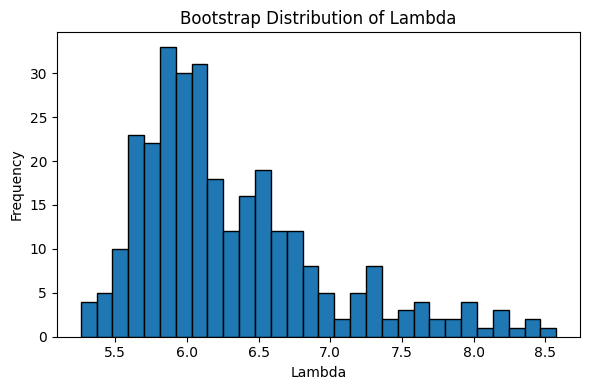

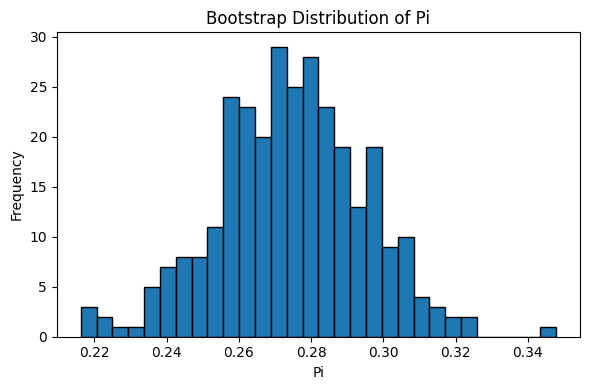

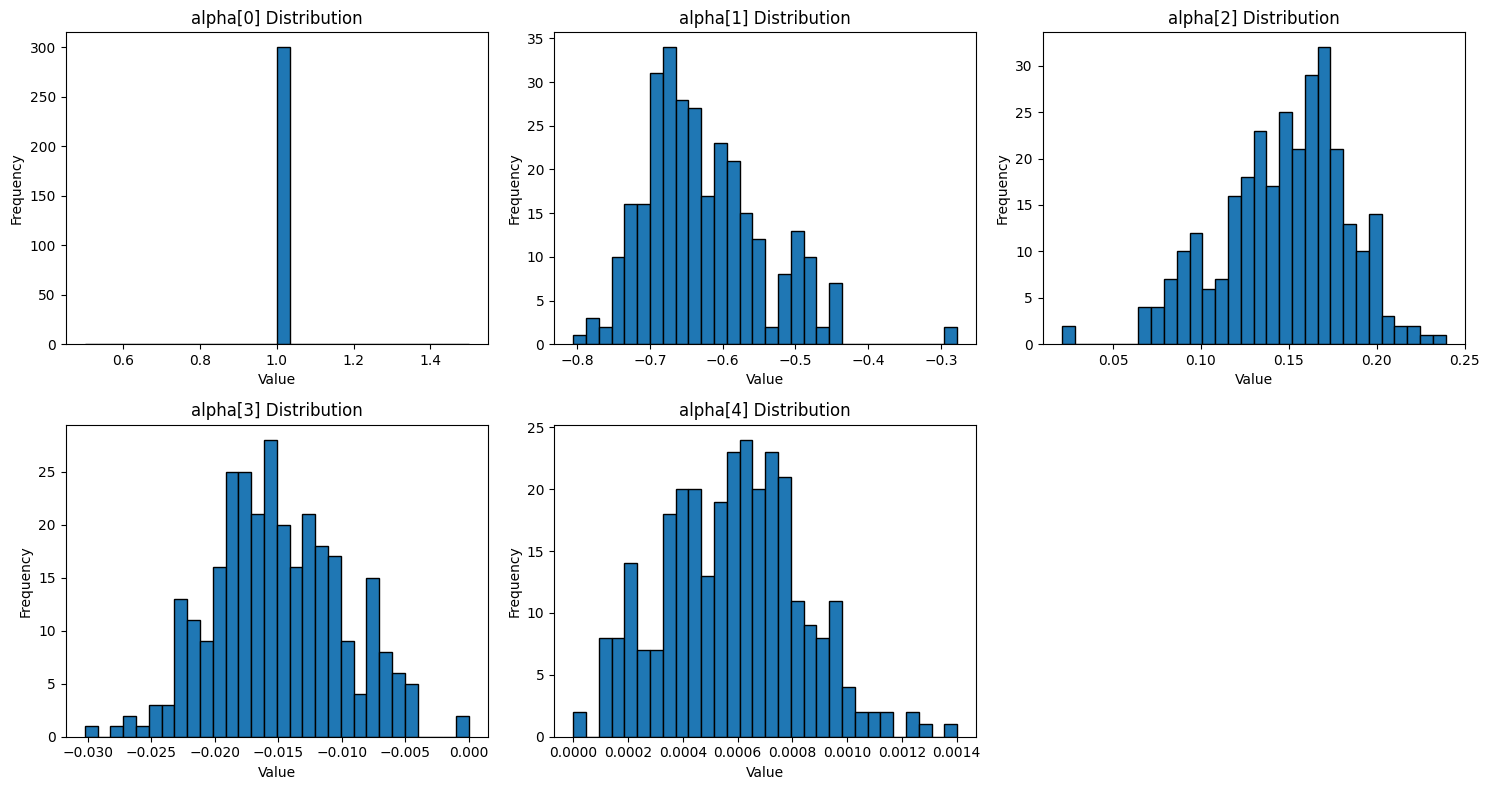

In [90]:
# 1) 파라미터 꺼내기
lams   = result1_300['lambda']          # shape = (100,)
pis    = result1_300['pi']              # shape = (100,)
alphas = result1_300['alpha']           # shape = (100, alpha_len)

# --- Lambda 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(lams, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Lambda')
plt.xlabel('Lambda')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Pi 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(pis, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Alpha 컴포넌트별 히스토그램 ---
num_alpha = alphas.shape[1]
ncols     = 3
nrows     = math.ceil(num_alpha / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axs = axs.flatten()

for j in range(num_alpha):
    ax = axs[j]
    ax.hist(alphas[:, j], bins=30, edgecolor='black')
    ax.set_title(f'alpha[{j}] Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# 남은 subplot 숨기기
for k in range(num_alpha, len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()

### 100, 300번에 대해서 정보 요약한 값들

In [117]:
import numpy as np

def summarize_bootstrap(boot_res):
    """
    Bootstrap 결과 요약: 평균(mean), 표준편차(std), 95% CI(2.5%, 97.5%)를 계산하고
    Markdown 표 형태로 출력하며, 요약 dict를 리턴합니다.
    """
    lam = boot_res['lambda']
    pi  = boot_res['pi']
    alpha = boot_res['alpha']  # shape (B, L)

    # λ 요약
    lam_mean = lam.mean()
    lam_std  = lam.std(ddof=1)
    lam_ci   = np.percentile(lam, [2.5, 97.5])

    # π 요약
    pi_mean = pi.mean()
    pi_std  = pi.std(ddof=1)
    pi_ci   = np.percentile(pi, [2.5, 97.5])

    # α 요약
    alpha_stats = []
    for j in range(alpha.shape[1]):
        a_j = alpha[:, j]
        m = a_j.mean()
        s = a_j.std(ddof=1)
        ci = np.percentile(a_j, [2.5, 97.5])
        alpha_stats.append({'mean': m, 'std': s, 'ci95': tuple(ci)})

    # Markdown 표 헤더
    print("| Parameter |   Mean   | Std Dev  | 95% CI Lower | 95% CI Upper |")
    print("|:---------:|:--------:|:--------:|:------------:|:------------:|")

    # λ 한 줄
    print(f"| λ        | {lam_mean:8.4f} | {lam_std:8.4f} | {lam_ci[0]:12.4f} | {lam_ci[1]:12.4f} |")

    # π 한 줄
    print(f"| π        | {pi_mean:8.4f} | {pi_std:8.4f} | {pi_ci[0]:12.4f} | {pi_ci[1]:12.4f} |")

    # α 줄들
    for j, stats in enumerate(alpha_stats):
        m, s, (lo, hi) = stats['mean'], stats['std'], stats['ci95']
        print(f"| α[{j}]     | {m:8.4f} | {s:8.4f} | {lo:12.4f} | {hi:12.4f} |")

    # 요약 dict 생성 및 리턴
    summary = {
        'lambda': {'mean': lam_mean, 'std': lam_std, 'ci95': tuple(lam_ci)},
        'pi':     {'mean': pi_mean,  'std': pi_std,  'ci95': tuple(pi_ci)},
        'alpha':  alpha_stats
    }
    return summary

In [118]:
stats = summarize_bootstrap(result1_300)

print("λ:", stats['lambda'])
print("π:", stats['pi'])
for i, a in enumerate(stats['alpha']):
    print(f"α[{i}]:", a)

| Parameter |   Mean   | Std Dev  | 95% CI Lower | 95% CI Upper |
|:---------:|:--------:|:--------:|:------------:|:------------:|
| λ        |   6.3050 |   0.6565 |       5.4619 |       8.0100 |
| π        |   0.2747 |   0.0205 |       0.2359 |       0.3131 |
| α[0]     |   1.0000 |   0.0000 |       1.0000 |       1.0000 |
| α[1]     |  -0.6263 |   0.0820 |      -0.7438 |      -0.4474 |
| α[2]     |   0.1474 |   0.0355 |       0.0735 |       0.2053 |
| α[3]     |  -0.0151 |   0.0051 |      -0.0244 |      -0.0051 |
| α[4]     |   0.0006 |   0.0002 |       0.0001 |       0.0011 |
λ: {'mean': np.float64(6.305031529517031), 'std': np.float64(0.6564770844961221), 'ci95': (np.float64(5.461875926751351), np.float64(8.009972646335957))}
π: {'mean': np.float64(0.27473120407622964), 'std': np.float64(0.020530525875659147), 'ci95': (np.float64(0.2359185482507808), np.float64(0.3130714416019136))}
α[0]: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'ci95': (np.float64(1.0), np.float64(1.0))}

In [120]:
stats = summarize_bootstrap(result1_100)

print("λ:", stats['lambda'])
print("π:", stats['pi'])
for i, a in enumerate(stats['alpha']):
    print(f"α[{i}]:", a)

| Parameter |   Mean   | Std Dev  | 95% CI Lower | 95% CI Upper |
|:---------:|:--------:|:--------:|:------------:|:------------:|
| λ        |   6.1972 |   0.6139 |       5.3463 |       7.7613 |
| π        |   0.2744 |   0.0212 |       0.2351 |       0.3105 |
| α[0]     |   1.0000 |   0.0000 |       1.0000 |       1.0000 |
| α[1]     |  -0.6408 |   0.0746 |      -0.7760 |      -0.4672 |
| α[2]     |   0.1539 |   0.0337 |       0.0860 |       0.2224 |
| α[3]     |  -0.0160 |   0.0051 |      -0.0271 |      -0.0065 |
| α[4]     |   0.0006 |   0.0003 |       0.0002 |       0.0012 |
λ: {'mean': np.float64(6.197209930892629), 'std': np.float64(0.6139024972560585), 'ci95': (np.float64(5.346295880540087), np.float64(7.761339374500875))}
π: {'mean': np.float64(0.2743785470857144), 'std': np.float64(0.021217789617537147), 'ci95': (np.float64(0.23507011974353648), np.float64(0.3105304661919962))}
α[0]: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'ci95': (np.float64(1.0), np.float64(1.0))}

#### 500회를 사용하여 접근한다

In [121]:
result1_500 = bootstrap_zipap_until_success(y_all, 4, n_boot=500, random_seed=42,
                                 alpha_thresh=1e3, max_tries=1000) # y_all, 4, n_boot=300

Success 1/500 (Try 1): λ=5.9764, π=0.2434, α=[ 1.000e+00 -6.675e-01  1.627e-01 -1.690e-02  7.000e-04]
Success 2/500 (Try 2): λ=5.6138, π=0.2623, α=[ 1.000e+00 -6.968e-01  1.771e-01 -1.910e-02  8.000e-04]
Success 3/500 (Try 3): λ=6.1589, π=0.2709, α=[ 1.000e+00 -6.396e-01  1.501e-01 -1.500e-02  6.000e-04]
Success 4/500 (Try 4): λ=7.7509, π=0.3079, α=[ 1.000e+00 -5.016e-01  9.270e-02 -7.200e-03  2.000e-04]
Success 5/500 (Try 5): λ=6.4793, π=0.2795, α=[ 1.000e+00 -6.088e-01  1.381e-01 -1.340e-02  5.000e-04]
Success 6/500 (Try 6): λ=5.6334, π=0.2501, α=[ 1.000e+00 -7.277e-01  1.954e-01 -2.220e-02  9.000e-04]
Success 7/500 (Try 7): λ=5.9932, π=0.2615, α=[ 1.000e+00 -6.838e-01  1.706e-01 -1.800e-02  7.000e-04]
Success 8/500 (Try 8): λ=5.8255, π=0.2587, α=[ 1.000e+00 -6.700e-01  1.634e-01 -1.690e-02  6.000e-04]
Success 9/500 (Try 9): λ=6.1041, π=0.2676, α=[ 1.000e+00 -6.289e-01  1.501e-01 -1.560e-02  6.000e-04]
Success 10/500 (Try 10): λ=6.2006, π=0.2870, α=[ 1.000e+00 -6.046e-01  1.369e-01 -

KeyboardInterrupt: 

### 코드 수정해서 접근
- 이 방법은 시작 파라미터를 ZIPAP의 최적 파라미터를 시작점으로 두고 접근하는 방법임 : 0에서 시작하는 방법이 아님/

In [ ]:
def bootstrap_zipap(y, degree, n_boot=200, init_theta=None, random_seed=42):
    rng = np.random.RandomState(random_seed)
    n = len(y)
    r0 = degree // 2
    r1 = (degree - 1)//2 if degree > 0 else -1
    alpha_len = max(2*r0, 1+2*r1) + 1
    lam_vals = np.empty(n_boot)
    pi_vals  = np.empty(n_boot)
    alpha_vals = np.zeros((n_boot, alpha_len))
    success   = np.zeros(n_boot, dtype=bool)
    for i in range(n_boot):
        # 부트스트랩 진행 상황 표시
        print(f"Bootstrap iteration {i+1}/{n_boot}")
        yb = rng.choice(y, size=n, replace=True)
        model = ZIPAP(degree=degree, y=yb)
        # MLE 기반 초기값으로 시작
        if init_theta is not None:
            model.theta = init_theta.copy()
        try:
            model.fit()
            success[i]    = True
            lam_vals[i]   = np.exp(model.theta[0])
            pi_vals[i]    = 1/(1+np.exp(-model.theta[-1]))
            u1 = model.theta[1:1+r0]
            v  = model.theta[1+r0:1+r0+(r1+1)]
            alpha_vals[i] = compute_alpha(np.concatenate(([1.0], u1)), v)
            # 각 반복별 결과 출력
            print(f"  -> lambda={lam_vals[i]:.4f}, pi={pi_vals[i]:.4f}, alpha={np.round(alpha_vals[i],4)}")
        except RuntimeError:
            continue
    return {'lambda': lam_vals[success], 'pi': pi_vals[success], 'alpha': alpha_vals[success], 'success': success}

# 부트스트랩 실행
boot_res    = bootstrap_zipap(y_all, degree=4, n_boot=300, init_theta=theta_mle)
lam_samps   = boot_res['lambda']
pi_samps    = boot_res['pi']
alpha_samps = boot_res['alpha']

# summary & covariance
param_samples = np.column_stack([lam_samps, pi_samps, alpha_samps])
cov_matrix    = np.cov(param_samples, rowvar=False)
print("Covariance matrix (bootstrap):")
print(cov_matrix)

In [ ]:
# 1) 파라미터 꺼내기
lams   = boot_res['lambda']          # shape = (100,)
pis    = boot_res['pi']              # shape = (100,)
alphas = boot_res['alpha']           # shape = (100, alpha_len)

# --- Lambda 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(lams, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Lambda')
plt.xlabel('Lambda')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Pi 히스토그램 ---
plt.figure(figsize=(6,4))
plt.hist(pis, bins=30, edgecolor='black')
plt.title('Bootstrap Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Alpha 컴포넌트별 히스토그램 ---
num_alpha = alphas.shape[1]
ncols     = 3
nrows     = math.ceil(num_alpha / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axs = axs.flatten()

for j in range(num_alpha):
    ax = axs[j]
    ax.hist(alphas[:, j], bins=30, edgecolor='black')
    ax.set_title(f'alpha[{j}] Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# 남은 subplot 숨기기
for k in range(num_alpha, len(axs)):
    axs[k].axis('off')

plt.tight_layout()
plt.show()